# Fairness Pipeline - Complete Integrated Demo

**FairML Consulting - End-to-End Fairness Toolkit Demonstration**

This notebook demonstrates the complete fairness pipeline integrating all 4 modules:

1. **📊 Measurement Module** - Baseline fairness metrics
2. **🔍 Pipeline Module** - Bias detection and mitigation
3. **🎓 Training Module** - Fairness-aware model training
4. **📈 Monitoring Module** - Production fairness tracking

## Workflow

```
Data → Measure Baseline → Detect Bias → Mitigate → Train Fair Model → Validate → Setup Monitoring
```

## Setup and Configuration

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set random seeds
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Standard imports complete")

✅ Standard imports complete


In [6]:
# Cell 1: Setup Path
import sys
from pathlib import Path

# Get the current notebook directory
notebook_dir = Path.cwd()

# If we are in the root folder, add it. 
# If we are inside a subfolder, go up one level.
if (notebook_dir / "measurement_module").exists():
    project_root = notebook_dir
else:
    # Assuming notebook is in the root, try parent just in case
    project_root = notebook_dir.parent

# Add project root to sys.path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"✅ Project root set to: {project_root}")

✅ Project root set to: d:\Research\Turing\TuringProject\fairness_toolkit


In [7]:
# Import all 4 modules
print("Importing fairness toolkit modules...")

# Module 1: Measurement
from measurement_module.src import FairnessAnalyzer
from measurement_module.src.mlops_integration import log_fairness_metrics_to_mlflow, log_fairness_report

# Module 2: Pipeline (Bias Detection & Mitigation)
from pipeline_module.src.bias_detection import BiasDetector
from pipeline_module.src.transformers.reweighting import InstanceReweighting
from pipeline_module.src.transformers.resampling import GroupBalancer

# Module 3: Training (Fair Model Training)
from training_module.src.sklearn_wrappers import ReductionsWrapper
from training_module.src.calibration import GroupFairnessCalibrator

# Module 4: Monitoring (Production Tracking)
from monitoring_module.src.realtime_tracker import RealTimeFairnessTracker
from monitoring_module.src.drift_detection import FairnessDriftDetector

print("✅ All 4 modules imported successfully")
print("\n📦 Available Components:")
print("  Module 1: FairnessAnalyzer")
print("  Module 2: BiasDetector, InstanceReweighting, GroupResampler")
print("  Module 3: ReductionsWrapper, GroupFairnessCalibrator")
print("  Module 4: RealTimeFairnessTracker, FairnessDriftDetector")

Importing fairness toolkit modules...
✅ All 4 modules imported successfully

📦 Available Components:
  Module 1: FairnessAnalyzer
  Module 2: BiasDetector, InstanceReweighting, GroupResampler
  Module 3: ReductionsWrapper, GroupFairnessCalibrator
  Module 4: RealTimeFairnessTracker, FairnessDriftDetector


In [8]:
# MLflow setup (optional)
try:
    import mlflow
    mlflow.set_experiment("fairness_pipeline_demo")
    MLFLOW_AVAILABLE = True
    print("✅ MLflow available - experiment tracking enabled")
    print("   Run 'mlflow ui' to view results")
except ImportError:
    MLFLOW_AVAILABLE = False
    print("⚠️  MLflow not available (install with: pip install mlflow)")
    print("   Continuing without experiment tracking")

2026/01/16 19:24:46 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/16 19:24:46 INFO mlflow.store.db.utils: Updating database tables
2026/01/16 19:24:46 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/16 19:24:46 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/16 19:24:46 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/16 19:24:46 INFO alembic.runtime.migration: Will assume non-transactional DDL.


✅ MLflow available - experiment tracking enabled
   Run 'mlflow ui' to view results


## 1. Load Configuration and Data

In [9]:
# Load configuration
config_path = Path('config.yml')

if config_path.exists():
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    print("✅ Loaded configuration from config.yml")
else:
    # Use default configuration
    config = {
        'fairness_threshold': 0.1,
        'bootstrap_samples': 1000,
        'fairness_metrics': ['demographic_parity', 'equalized_odds', 'equal_opportunity'],
        'bias_detection': {
            'protected_attribute': 'gender',
            'representation_threshold': 0.2,
            'proxy_threshold': 0.5
        },
        'bias_mitigation': {
            'method': 'reweighting',
            'params': {}
        },
        'training': {
            'use_fairness_constraints': True,
            'constraint_type': 'demographic_parity',
            'eps': 0.05
        },
        'monitoring': {
            'window_size': 1000,
            'drift_threshold': 0.05
        }
    }
    print("⚠️  Using default configuration (config.yml not found)")

print("\n📋 Configuration:")
print(f"  Fairness threshold: {config['fairness_threshold']}")
print(f"  Metrics: {config['fairness_metrics']}")
print(f"  Mitigation method: {config['bias_mitigation']['method']}")
print(f"  Use fairness constraints: {config['training']['use_fairness_constraints']}")

✅ Loaded configuration from config.yml

📋 Configuration:
  Fairness threshold: 0.1
  Metrics: ['demographic_parity', 'equalized_odds']
  Mitigation method: reweighting
  Use fairness constraints: False


In [10]:
# Generate synthetic loan approval dataset
def generate_loan_data(n_samples=2000, bias_strength=0.4):
    """
    Generate realistic biased loan approval data.
    
    Args:
        n_samples: Number of samples
        bias_strength: Strength of bias (0-1)
    """
    np.random.seed(42)
    
    # Protected attribute (gender: 0=Female, 1=Male)
    gender = np.random.binomial(1, 0.5, n_samples)
    
    # Features (credit score, income, debt ratio, employment years)
    credit_score = np.random.normal(700, 50, n_samples)
    income = np.random.lognormal(11, 0.5, n_samples)  # ~$60k median
    debt_ratio = np.random.beta(2, 5, n_samples)
    employment_years = np.random.exponential(5, n_samples)
    
    # Add historical bias (gender affects features)
    credit_score += gender * 15
    income *= (1 + gender * 0.15)
    
    # True creditworthiness (unbiased)
    creditworthiness = (
        0.4 * (credit_score - 650) / 100 +
        0.3 * np.log(income / 50000) +
        -0.3 * debt_ratio +
        0.1 * np.minimum(employment_years / 10, 1)
    )
    
    # True labels (would default)
    prob_default = 1 / (1 + np.exp(creditworthiness))
    creditworthy = (prob_default < 0.3).astype(int)
    
    # Create DataFrame
    df = pd.DataFrame({
        'credit_score': credit_score,
        'income': income,
        'debt_ratio': debt_ratio,
        'employment_years': employment_years,
        'gender': gender,
        'creditworthy': creditworthy
    })
    
    return df

# Generate data
df = generate_loan_data(n_samples=2000, bias_strength=0.4)

print("✅ Generated synthetic loan approval dataset")
print(f"\n📊 Dataset Overview:")
print(f"  Total samples: {len(df)}")
print(f"  Features: {len(df.columns) - 2}")
print(f"  Gender distribution: {df['gender'].value_counts().to_dict()}")
print(f"  Creditworthy rate: {df['creditworthy'].mean():.2%}")
print(f"\nFirst few rows:")
df.head()

✅ Generated synthetic loan approval dataset

📊 Dataset Overview:
  Total samples: 2000
  Features: 4
  Gender distribution: {1: 1013, 0: 987}
  Creditworthy rate: 1.15%

First few rows:


,credit_score,income,debt_ratio,employment_years,gender,creditworthy
0,656.100871,71207.611075,0.190251,5.039222,0,0
1,673.655982,241721.186290,0.420940,1.724107,1,0
2,703.676055,27439.066734,0.199207,7.839863,1,0
3,733.368275,67752.838656,0.131884,8.254174,1,0
4,745.679231,82476.729638,0.212675,3.116123,0,0


In [11]:
# Prepare data
feature_cols = ['credit_score', 'income', 'debt_ratio', 'employment_years']
target_col = 'creditworthy'
protected_attr = 'gender'

X = df[feature_cols].values
y = df[target_col].values
sensitive = df[protected_attr].values

# Train/test split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print("✅ Data prepared for pipeline")
print(f"  Training set: {len(X_train)} samples")
print(f"  Test set: {len(X_test)} samples")
print(f"  Features: {feature_cols}")

✅ Data prepared for pipeline
  Training set: 1400 samples
  Test set: 600 samples
  Features: ['credit_score', 'income', 'debt_ratio', 'employment_years']


## 2. Step 1: Baseline Measurement

Train a baseline model and measure its fairness properties.

In [12]:
print("="*70)
print("STEP 1: BASELINE MEASUREMENT")
print("="*70)

# Example with a sample dataset:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train baseline model (no fairness considerations)
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"\n📊 Baseline Model Performance:")
print(f"  Test Accuracy: {baseline_accuracy:.4f}")

# Measure fairness
analyzer = FairnessAnalyzer(
    bootstrap_samples=config['bootstrap_samples'],
    random_state=42
)

baseline_fairness = analyzer.compute_all_metrics(
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=s_test,
    threshold=config['fairness_threshold'],
    compute_ci=True
)

print(f"\n⚖️  Baseline Fairness Metrics:")
print("-" * 70)

baseline_summary = []
for metric_name, result in baseline_fairness.items():
    status = '✅ FAIR' if result.is_fair else '❌ UNFAIR'
    baseline_summary.append({
        'Metric': metric_name.replace('_', ' ').title(),
        'Value': f"{result.value:.4f}",
        'Threshold': result.threshold,
        '95% CI': f"[{result.confidence_interval[0]:.4f}, {result.confidence_interval[1]:.4f}]",
        'Status': status
    })

baseline_df = pd.DataFrame(baseline_summary)
print(baseline_df.to_string(index=False))

# Overall assessment
all_fair = all(r.is_fair for r in baseline_fairness.values())
print(f"\n{'='*70}")
if all_fair:
    print("✅ BASELINE: ALL METRICS PASSED")
else:
    print("❌ BASELINE: FAIRNESS ISSUES DETECTED")
    print("   → Proceeding with bias detection and mitigation")
print(f"{'='*70}")

STEP 1: BASELINE MEASUREMENT

📊 Baseline Model Performance:
  Test Accuracy: 0.9917
2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:21,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:21,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:21,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:21,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:25:21,148 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21,149 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:21,151 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:21,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-16 19:25:21,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:21,162 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:21,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:21,168 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21,170 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21,172 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:25:21,177 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:21,180 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0210


2026-01-16 19:25:21,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0210


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:21,188 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-16 19:25:21,192 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:21,195 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21,199 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21,202 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:21,206 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21,208 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:25:21,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21,215 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:21,217 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:21,217 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:21,224 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:21,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:21,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:21,234 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:21,238 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:25:21,242 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:21,245 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:21,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:21,250 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:21,256 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:21,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:21,262 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:25:21,264 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:21,270 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:21,272 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21,275 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-16 19:25:21,278 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:21,281 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21,284 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:21,287 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:21,290 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:21,294 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0227


2026-01-16 19:25:21,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0227


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-16 19:25:21,301 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:25:21,304 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:21,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:21,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:21,317 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:21,321 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:25:21,325 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:25:21,328 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:21,331 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21,335 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:21,338 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:21,341 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:21,348 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0182


2026-01-16 19:25:21,371 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0182


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:21,376 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21,384 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:21,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:21,401 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:21,404 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:21,408 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21,412 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21,416 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0323


2026-01-16 19:25:21,419 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0323


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21,423 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21,427 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:21,431 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-16 19:25:21,434 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:21,438 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:21,441 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21,445 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:21,449 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:21,453 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:25:21,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:21,461 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:25:21,472 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:25:21,474 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:25:21,477 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:21,480 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-16 19:25:21,483 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:21,485 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-16 19:25:21,487 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:21,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21,494 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:21,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:21,509 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:21,512 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:21,516 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:21,520 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21,523 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:21,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:21,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:21,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:21,539 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:21,543 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:21,549 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-16 19:25:21,552 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0157


2026-01-16 19:25:21,555 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0157


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:21,558 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:21,562 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:21,566 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:21,569 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:25:21,574 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0166


2026-01-16 19:25:21,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0166


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21,581 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:21,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:21,589 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:21,592 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:21,595 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:21,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:21,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:21,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:21,609 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:21,612 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:21,616 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:21,621 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21,625 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:21,629 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:21,633 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:21,637 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:25:21,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:21,647 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:21,651 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:21,655 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21,660 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:25:21,664 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:21,672 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:21,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:21,681 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:21,685 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:21,689 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:21,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:21,700 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:21,703 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:25:21,706 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:25:21,710 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:21,715 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:21,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:25:21,725 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:21,728 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:25:21,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21,742 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:21,746 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:21,750 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:21,753 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:21,757 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:21,761 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:21,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:21,771 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:21,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:25:21,777 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:21,780 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:21,783 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:25:21,786 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:21,788 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:25:21,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:21,793 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:21,797 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:21,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:21,802 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:21,805 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:21,808 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:21,812 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:25:21,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0190


2026-01-16 19:25:21,821 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0190


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:21,825 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21,828 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21,830 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:21,833 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:25:21,835 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:21,839 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:21,843 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:25:21,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-16 19:25:21,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21,855 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21,858 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21,863 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21,874 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:21,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:21,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:21,883 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:21,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:21,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:21,894 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:21,898 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:21,900 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21,903 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:21,905 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:21,910 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:21,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0113


2026-01-16 19:25:21,917 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0113


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:25:21,921 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:21,927 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:25:21,930 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:21,934 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:25:21,937 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:21,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:21,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:21,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-16 19:25:21,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21,952 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:21,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:25:21,961 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:21,964 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:21,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:21,972 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21,975 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:21,979 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:21,983 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:21,985 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-16 19:25:21,988 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:21,992 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:21,996 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:25:21,999 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:22,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:25:22,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:22,008 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158


2026-01-16 19:25:22,012 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:25:22,014 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:22,017 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22,019 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22,023 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:22,029 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:25:22,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:25:22,035 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:22,038 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:22,042 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:25:22,047 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:22,056 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:22,078 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:25:22,083 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:25:22,087 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:22,091 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:22,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:25:22,098 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:25:22,102 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:22,106 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:22,108 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:25:22,115 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:25:22,119 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:22,123 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:22,127 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:22,131 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:25:22,136 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:22,141 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:22,144 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:22,149 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:22,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:22,157 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:22,161 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:22,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:22,169 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:22,173 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:22,178 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:22,181 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-16 19:25:22,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:22,196 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:22,201 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:22,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:25:22,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:22,220 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:25:22,224 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:22,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:22,232 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:25:22,243 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:25:22,247 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:22,255 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:22,260 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:22,263 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:25:22,268 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:22,271 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:22,275 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:22,279 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22,283 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0220


2026-01-16 19:25:22,286 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0220


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22,289 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:22,293 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:22,299 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-16 19:25:22,304 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22,309 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22,313 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:22,319 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0225


2026-01-16 19:25:22,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0225


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:22,327 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:22,332 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:22,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:22,342 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:22,347 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:22,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:25:22,356 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:22,360 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:25:22,364 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:22,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:22,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:22,377 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0220


2026-01-16 19:25:22,382 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0220


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:22,386 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:22,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:22,394 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:22,398 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22,402 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:22,407 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:25:22,411 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22,416 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22,424 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:22,429 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:25:22,432 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:22,437 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:22,444 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:22,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:22,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:22,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:22,464 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:22,469 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:22,473 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:22,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:22,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:22,486 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:22,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:22,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:22,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:22,510 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:25:22,514 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22,517 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:22,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22,526 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:22,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:22,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:22,540 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0175


2026-01-16 19:25:22,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0175


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:22,550 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-16 19:25:22,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:25:22,559 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:22,564 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:25:22,569 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:22,573 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:22,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:22,581 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:22,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:22,590 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:22,594 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:22,598 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0163


2026-01-16 19:25:22,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0163


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22,611 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:22,613 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:22,619 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:25:22,623 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:22,628 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:25:22,632 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:22,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:22,639 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:22,643 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:22,649 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:22,653 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:22,661 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22,665 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:25:22,670 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:22,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:22,678 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:22,681 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22,686 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:22,690 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22,694 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:25:22,698 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22,702 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22,706 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-16 19:25:22,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:22,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0181


2026-01-16 19:25:22,718 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0181


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:22,723 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:22,727 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22,731 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22,735 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:22,738 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:22,743 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:22,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:22,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-16 19:25:22,755 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:22,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:25:22,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:22,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:22,772 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:22,776 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:22,781 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-16 19:25:22,786 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:22,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:22,794 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:25:22,800 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:25:22,804 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:22,808 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:22,811 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:22,815 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:22,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:22,823 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0178


2026-01-16 19:25:22,828 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0178


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:22,831 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:22,835 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:22,840 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:22,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:25:22,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:22,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:22,854 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:22,858 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:22,862 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:25:22,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:22,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:22,874 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:22,878 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:22,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0187


2026-01-16 19:25:22,885 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0187


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:22,888 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:22,892 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:22,896 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:25:22,899 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:25:22,902 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:22,906 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:22,909 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:22,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:22,919 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:22,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:22,936 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:25:22,940 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:22,949 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:22,952 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:22,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:22,960 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:25:22,965 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:25:22,968 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:22,972 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22,975 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:22,980 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22,983 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:25:22,991 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:22,995 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:22,998 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:25:23,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0181


2026-01-16 19:25:23,009 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0181


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:23,013 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-16 19:25:23,017 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:23,021 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:23,025 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:25:23,028 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:23,032 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:23,036 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-16 19:25:23,040 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:23,044 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:23,048 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:23,050 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:23,053 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:23,057 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:23,059 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:23,063 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:23,065 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23,068 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:23,088 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0174


2026-01-16 19:25:23,092 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0174


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:23,096 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:23,100 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:23,103 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:23,107 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23,111 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:23,114 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:23,117 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23,121 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:23,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:23,129 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:23,131 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0226


2026-01-16 19:25:23,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0226


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:23,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:23,140 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:23,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:23,145 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:25:23,149 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:25:23,151 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:23,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:23,157 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:23,159 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:23,161 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-16 19:25:23,164 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:23,179 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:25:23,182 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:23,186 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:23,189 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:23,193 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:25:23,196 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23,202 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:23,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:23,208 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:23,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:23,214 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:23,217 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:25:23,221 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-16 19:25:23,225 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:23,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:23,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23,235 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:23,239 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23,242 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:23,245 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:25:23,249 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:23,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:23,256 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:23,264 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-16 19:25:23,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23,272 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:25:23,276 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:23,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23,283 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23,286 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:25:23,291 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:25:23,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:25:23,302 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23,307 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23,316 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:23,320 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:23,325 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:23,329 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:23,331 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:23,334 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:23,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:25:23,340 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:23,344 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:23,346 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:23,349 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:23,353 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:23,356 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:25:23,359 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0215


2026-01-16 19:25:23,363 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0215


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:23,366 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:25:23,368 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23,371 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:23,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-16 19:25:23,375 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:25:23,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:23,382 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:23,385 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:25:23,389 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:23,394 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:23,398 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:23,401 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:23,404 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:25:23,410 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23,415 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:23,419 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23,423 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:23,426 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:23,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:23,433 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:23,436 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:23,441 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:25:23,444 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23,447 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:23,451 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:23,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:25:23,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:23,464 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:25:23,468 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:23,472 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:23,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:25:23,479 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:23,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:23,486 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:23,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:23,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:23,503 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:25:23,508 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23,513 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:23,523 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:23,528 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:23,532 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0174


2026-01-16 19:25:23,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0174


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23,541 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:23,544 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:23,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:23,551 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:23,567 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:25:23,572 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0187


2026-01-16 19:25:23,574 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0187


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:23,578 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:23,581 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:23,583 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:23,586 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:23,597 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:23,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:23,617 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:23,620 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:23,624 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:23,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:23,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:23,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23,639 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:23,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:23,648 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:23,652 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:25:23,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:25:23,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:23,680 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:25:23,684 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:23,688 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23,690 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:25:23,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:23,700 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:23,703 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0113


2026-01-16 19:25:23,707 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0113


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:23,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:23,715 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23,724 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:23,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:23,733 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0272


2026-01-16 19:25:23,740 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0272


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:25:23,743 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:25:23,746 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:23,749 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:25:23,752 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23,754 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:23,758 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:25:23,769 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:23,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:23,779 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:23,783 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23,786 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:25:23,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23,793 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:23,798 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:23,802 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:23,805 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:23,808 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-16 19:25:23,814 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:23,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:25:23,821 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:25:23,824 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:23,828 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:23,833 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:23,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:23,841 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:23,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:23,849 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0174


2026-01-16 19:25:23,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0174


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:23,855 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:23,858 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0227


2026-01-16 19:25:23,862 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0227


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:23,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:23,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:23,874 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-16 19:25:23,877 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:23,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:23,885 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:23,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:25:23,893 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:23,897 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:25:23,900 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:23,904 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-16 19:25:23,904 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:23,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:23,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:23,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:23,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:23,928 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:25:23,932 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0140


2026-01-16 19:25:23,936 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0140


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0181


2026-01-16 19:25:23,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0181


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:23,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:23,948 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:25:23,953 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:23,957 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:25:23,961 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-16 19:25:23,965 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:23,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23,972 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:23,976 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23,982 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:23,986 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:23,990 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:23,994 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:24,001 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:25:24,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24,009 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:24,014 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:24,018 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:24,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:24,028 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:24,032 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:24,037 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:24,041 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:24,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:24,050 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:24,055 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:24,059 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:24,064 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:24,069 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:24,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:24,078 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:24,082 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24,087 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:24,090 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:25:24,093 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:24,098 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:25:24,101 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:24,106 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:25:24,110 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0151


2026-01-16 19:25:24,113 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0151


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:24,117 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:24,122 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:24,125 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:24,129 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:24,132 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:24,136 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:25:24,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:24,141 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:24,145 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:24,148 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:25:24,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:24,156 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:25:24,161 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:24,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:24,168 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:24,173 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:24,177 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:24,182 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:24,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:24,188 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:24,192 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:24,196 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:24,201 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:25:24,210 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:24,214 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:24,218 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:24,222 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24,227 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:24,235 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:24,240 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:24,244 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:24,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:24,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:24,256 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:24,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24,264 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:24,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:24,270 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24,274 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:25:24,277 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:24,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:24,283 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:24,286 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-16 19:25:24,290 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24,294 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0113


2026-01-16 19:25:24,296 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0113


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:25:24,301 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:25:24,303 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:24,306 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:24,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:24,311 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:24,314 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:24,317 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:24,320 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:25:24,324 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:24,326 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:24,331 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:24,333 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:24,336 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:24,340 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:24,343 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:25:24,346 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:24,349 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:24,353 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24,357 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0295


2026-01-16 19:25:24,359 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0295


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24,363 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:24,368 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:24,371 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:24,375 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:24,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:24,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:24,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:24,395 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:24,399 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:24,405 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:24,408 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-16 19:25:24,413 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:24,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:25:24,421 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:24,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:24,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:24,434 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:24,437 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24,441 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-16 19:25:24,446 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:24,450 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:24,454 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:24,457 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:24,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:25:24,466 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:24,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:24,486 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:25:24,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:24,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:24,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:24,504 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:24,511 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:24,514 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:24,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:25:24,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:24,526 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:24,534 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0261


2026-01-16 19:25:24,537 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0261


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:24,541 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:24,545 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:24,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:24,552 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:24,561 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:24,566 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:24,569 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:24,571 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:24,573 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:24,581 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0175


2026-01-16 19:25:24,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0175


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24,588 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:24,591 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:24,594 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0214


2026-01-16 19:25:24,598 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0214


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:24,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:24,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:24,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24,610 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:24,614 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:24,617 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:24,620 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:24,623 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:24,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:24,632 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:24,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:24,638 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:24,640 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24,649 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:25:24,679 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24,683 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:24,687 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24,691 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:24,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:24,699 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:25:24,702 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:24,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:24,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24,712 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24,716 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:24,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:24,723 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:24,727 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:24,733 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:24,741 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:24,753 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:24,756 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:24,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:25:24,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0246


2026-01-16 19:25:24,767 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0246


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24,770 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:24,772 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:24,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:24,777 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24,779 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:24,783 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:25:24,785 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:24,788 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:25:24,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:24,806 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:24,810 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:24,813 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:24,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0134


2026-01-16 19:25:24,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0134


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:24,822 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:25:24,824 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:24,827 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:24,830 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:24,834 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24,838 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:24,840 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:24,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:25:24,848 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:24,850 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:25:24,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:24,855 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:24,857 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:25:24,859 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:24,863 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:24,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:25:24,873 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:24,875 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24,878 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:24,882 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:24,885 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:24,888 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0314


2026-01-16 19:25:24,892 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0314


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:24,896 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24,899 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:24,901 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:25:24,903 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24,906 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:24,910 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:24,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:24,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:24,919 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-16 19:25:24,922 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24,926 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:24,929 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:25:24,932 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-16 19:25:24,935 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:24,938 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:25:24,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:24,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:24,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:24,951 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-16 19:25:24,957 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24,962 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:24,965 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:24,968 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:24,971 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:24,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-16 19:25:24,977 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24,980 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:24,983 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:25:24,986 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:25:24,989 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:24,993 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:25:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:24,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:25,000 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:25,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:25:25,008 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:25,012 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:25:25,016 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:25,019 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:25,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:25:25,026 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:25,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:25:25,034 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:25,038 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:25,041 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:25,045 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:25,049 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:25,053 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:25,056 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:25,065 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:25:25,069 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:25,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:25,076 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:25,080 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:25,086 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:25,091 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:25,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:25,100 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0180


2026-01-16 19:25:25,104 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0180


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-16 19:25:25,108 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:25:25,113 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:25,117 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:25,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:25,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:25,128 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:25,141 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:25:25,149 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0030)


2026-01-16 19:25:25,158 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0030)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:25,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0034)


2026-01-16 19:25:25,177 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0005)


2026-01-16 19:25:25,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0005)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0036)


2026-01-16 19:25:25,197 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0036)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,203 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:25,206 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:25,217 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:25,225 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0000, FPR: 0.0028)


2026-01-16 19:25:25,234 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0000, FPR: 0.0028)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0000, FPR: 0.0038)


2026-01-16 19:25:25,243 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0000, FPR: 0.0038)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0032)


2026-01-16 19:25:25,250 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0032)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0071)


2026-01-16 19:25:25,258 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0071)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:25:25,266 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:25,272 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4545 (TPR: 0.4545, FPR: 0.0098)


2026-01-16 19:25:25,281 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4545 (TPR: 0.4545, FPR: 0.0098)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0004)


2026-01-16 19:25:25,290 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0004)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0011)


2026-01-16 19:25:25,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0011)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0058)


2026-01-16 19:25:25,310 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0058)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:25,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0026)


2026-01-16 19:25:25,327 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0026)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:25:25,336 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:25,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:25,355 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,361 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0068)


2026-01-16 19:25:25,363 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0068)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:25:25,369 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:25,375 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:25,383 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:25,395 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:25,419 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:25,430 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,436 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:25:25,439 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,445 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:25,447 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:25:25,455 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0097)


2026-01-16 19:25:25,463 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0097)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,470 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0070)


2026-01-16 19:25:25,472 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0070)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:25,491 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1250 (TPR: 0.1250, FPR: 0.0033)


2026-01-16 19:25:25,500 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1250 (TPR: 0.1250, FPR: 0.0033)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:25,507 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0063)


2026-01-16 19:25:25,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0063)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0101)


2026-01-16 19:25:25,522 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0101)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0074)


2026-01-16 19:25:25,530 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0074)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0136)


2026-01-16 19:25:25,542 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0136)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0075)


2026-01-16 19:25:25,550 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0075)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:25,557 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0002)


2026-01-16 19:25:25,565 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0002)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0034)


2026-01-16 19:25:25,574 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0072)


2026-01-16 19:25:25,585 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0072)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0070)


2026-01-16 19:25:25,593 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0070)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:25:25,599 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0033)


2026-01-16 19:25:25,606 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0033)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:25,613 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:25:25,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0094)


2026-01-16 19:25:25,633 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0094)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0024)


2026-01-16 19:25:25,639 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0024)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:25,648 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,655 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0070)


2026-01-16 19:25:25,658 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0070)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:25:25,665 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:25,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:25,684 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0052)


2026-01-16 19:25:25,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0052)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0063)


2026-01-16 19:25:25,697 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0063)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0059)


2026-01-16 19:25:25,706 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0059)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0086)


2026-01-16 19:25:25,715 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0086)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:25,722 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:25,730 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:25,738 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0108)


2026-01-16 19:25:25,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0108)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,750 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0068)


2026-01-16 19:25:25,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0068)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0002)


2026-01-16 19:25:25,758 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0002)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:25:25,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:25:25,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,777 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:25,778 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0022)


2026-01-16 19:25:25,786 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0022)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0099)


2026-01-16 19:25:25,794 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0099)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0064)


2026-01-16 19:25:25,803 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0064)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:25,808 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0071)


2026-01-16 19:25:25,816 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0071)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:25:25,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0071)


2026-01-16 19:25:25,837 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0071)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25,843 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0037 (TPR: 0.0000, FPR: 0.0037)


2026-01-16 19:25:25,845 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0037 (TPR: 0.0000, FPR: 0.0037)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:25,854 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:25,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0028)


2026-01-16 19:25:25,869 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0028)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:25,879 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:25,887 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0069)


2026-01-16 19:25:25,894 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0069)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:25,900 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0034)


2026-01-16 19:25:25,908 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0034)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:25,915 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:25:25,943 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:25,950 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:25:25,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0005)


2026-01-16 19:25:25,964 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0005)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:25,971 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:25,980 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:25,988 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:25 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0029)


2026-01-16 19:25:25,996 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0029)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:25:26,003 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0011)


2026-01-16 19:25:26,015 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0011)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0002)


2026-01-16 19:25:26,022 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0002)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0025)


2026-01-16 19:25:26,033 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0025)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0036)


2026-01-16 19:25:26,041 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:25:26,049 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26,054 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,060 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:26,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0037)


2026-01-16 19:25:26,069 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0037)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0098)


2026-01-16 19:25:26,086 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0098)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0036)


2026-01-16 19:25:26,092 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0003)


2026-01-16 19:25:26,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0003)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:26,101 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26,112 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:25:26,118 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0007)


2026-01-16 19:25:26,129 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0007)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0061)


2026-01-16 19:25:26,135 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0061)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:26,140 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0002)


2026-01-16 19:25:26,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0002)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:26,148 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,151 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0038)


2026-01-16 19:25:26,153 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0038)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:26,162 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0065)


2026-01-16 19:25:26,168 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0065)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,173 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:25:26,175 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0068)


2026-01-16 19:25:26,181 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0068)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:26,186 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0009)


2026-01-16 19:25:26,190 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0009)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0026)


2026-01-16 19:25:26,194 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0026)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0044)


2026-01-16 19:25:26,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0044)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:26,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0025)


2026-01-16 19:25:26,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0025)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:25:26,218 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0036)


2026-01-16 19:25:26,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,229 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:26,231 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:26,236 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0066)


2026-01-16 19:25:26,242 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0066)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,246 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0069)


2026-01-16 19:25:26,248 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0069)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:26,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0097)


2026-01-16 19:25:26,260 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0097)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0031)


2026-01-16 19:25:26,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0031)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:26,273 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:26,279 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:26,286 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26,293 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:26,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0027)


2026-01-16 19:25:26,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0027)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0078)


2026-01-16 19:25:26,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0078)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0005)


2026-01-16 19:25:26,318 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0005)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:26,325 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:25:26,332 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0097)


2026-01-16 19:25:26,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0097)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0029)


2026-01-16 19:25:26,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0029)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0002)


2026-01-16 19:25:26,351 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0002)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:26,357 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,362 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:25:26,364 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:25:26,368 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:26,376 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:26,382 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:26,387 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:26,394 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0036)


2026-01-16 19:25:26,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,404 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0070)


2026-01-16 19:25:26,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0070)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0069)


2026-01-16 19:25:26,409 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0069)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0048)


2026-01-16 19:25:26,413 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0048)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0072)


2026-01-16 19:25:26,417 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0072)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:25:26,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0038)


2026-01-16 19:25:26,424 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0038)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:26,429 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0001)


2026-01-16 19:25:26,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0001)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:26,438 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0027)


2026-01-16 19:25:26,445 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0027)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0032)


2026-01-16 19:25:26,449 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:26,456 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,460 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:26,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:25:26,466 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:25:26,470 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0039)


2026-01-16 19:25:26,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0039)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0039)


2026-01-16 19:25:26,483 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0039)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,487 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0071)


2026-01-16 19:25:26,489 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0071)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:25:26,493 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0003)


2026-01-16 19:25:26,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0003)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:26,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0070)


2026-01-16 19:25:26,508 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0070)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8889 (TPR: 0.8889, FPR: 0.0011)


2026-01-16 19:25:26,514 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8889 (TPR: 0.8889, FPR: 0.0011)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:26,520 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,524 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0073)


2026-01-16 19:25:26,525 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0073)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0059)


2026-01-16 19:25:26,533 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0059)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0064)


2026-01-16 19:25:26,537 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0064)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0001)


2026-01-16 19:25:26,541 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0001)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0028)


2026-01-16 19:25:26,550 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0028)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0011)


2026-01-16 19:25:26,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0011)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:25:26,561 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:26,566 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0029)


2026-01-16 19:25:26,573 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0029)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0027)


2026-01-16 19:25:26,579 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0027)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,584 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:26,585 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:26,591 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:26,604 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0028)


2026-01-16 19:25:26,609 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0028)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26,615 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:26,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:26,626 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0064)


2026-01-16 19:25:26,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0064)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0065)


2026-01-16 19:25:26,637 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0065)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0027)


2026-01-16 19:25:26,641 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0027)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0024)


2026-01-16 19:25:26,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0024)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:26,649 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0004 (TPR: 0.0000, FPR: 0.0004)


2026-01-16 19:25:26,649 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0004 (TPR: 0.0000, FPR: 0.0004)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:25:26,657 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:26,663 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0028)


2026-01-16 19:25:26,668 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0028)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:26,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0109)


2026-01-16 19:25:26,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0109)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:26,681 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:26,686 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:25:26,689 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26,694 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:26,698 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0034)


2026-01-16 19:25:26,702 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0034)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26,707 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0070)


2026-01-16 19:25:26,712 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0070)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0007)


2026-01-16 19:25:26,717 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0007)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0070)


2026-01-16 19:25:26,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0070)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0093)


2026-01-16 19:25:26,756 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0093)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0067)


2026-01-16 19:25:26,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0067)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0031)


2026-01-16 19:25:26,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0031)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0018)


2026-01-16 19:25:26,779 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0018)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0070)


2026-01-16 19:25:26,795 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0070)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0064)


2026-01-16 19:25:26,802 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0064)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:26,810 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:26,814 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0060)


2026-01-16 19:25:26,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0060)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0067)


2026-01-16 19:25:26,825 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0067)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0029)


2026-01-16 19:25:26,832 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0029)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,836 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:25:26,837 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0000)


2026-01-16 19:25:26,844 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0005)


2026-01-16 19:25:26,849 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0005)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:26,861 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0006)


2026-01-16 19:25:26,871 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0006)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:25:26,877 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0029)


2026-01-16 19:25:26,885 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0029)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0005)


2026-01-16 19:25:26,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0005)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0038)


2026-01-16 19:25:26,902 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0038)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:26,908 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0076)


2026-01-16 19:25:26,910 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0076)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:26,918 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0066)


2026-01-16 19:25:26,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0066)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0017)


2026-01-16 19:25:26,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0017)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,936 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:26,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0063)


2026-01-16 19:25:26,950 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0063)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:26,958 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:25:26,965 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0038)


2026-01-16 19:25:26,974 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0038)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26,977 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:25:26,981 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0038)


2026-01-16 19:25:26,987 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0038)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0037)


2026-01-16 19:25:26,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0037)


2026-01-16 19:25:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:26,999 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,007 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:27,007 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0000)


2026-01-16 19:25:27,016 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:27,023 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:27,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,038 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0067)


2026-01-16 19:25:27,042 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0067)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0030)


2026-01-16 19:25:27,050 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0030)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:25:27,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:27,065 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0031)


2026-01-16 19:25:27,066 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0031)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:25:27,080 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:27,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0066 (TPR: 0.0000, FPR: 0.0066)


2026-01-16 19:25:27,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0066 (TPR: 0.0000, FPR: 0.0066)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0068)


2026-01-16 19:25:27,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0068)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:27,114 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:27,122 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0034)


2026-01-16 19:25:27,131 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,137 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:27,139 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:27,148 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:25:27,155 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0030)


2026-01-16 19:25:27,164 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0030)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0074)


2026-01-16 19:25:27,174 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0074)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:27,181 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:27,188 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0068)


2026-01-16 19:25:27,196 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0068)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:27,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,211 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:27,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0031)


2026-01-16 19:25:27,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0031)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,229 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:25:27,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,237 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:25:27,239 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0063)


2026-01-16 19:25:27,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0063)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0064)


2026-01-16 19:25:27,259 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0064)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:25:27,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0034)


2026-01-16 19:25:27,275 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0028)


2026-01-16 19:25:27,283 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0028)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0038)


2026-01-16 19:25:27,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0038)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:27,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0099)


2026-01-16 19:25:27,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0099)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0033)


2026-01-16 19:25:27,314 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0066)


2026-01-16 19:25:27,324 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0066)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,330 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:27,332 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:27,341 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,349 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0035)


2026-01-16 19:25:27,351 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:25:27,358 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,369 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0067)


2026-01-16 19:25:27,372 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0067)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0035)


2026-01-16 19:25:27,383 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0068)


2026-01-16 19:25:27,390 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0068)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:27,393 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:27,398 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,403 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0033)


2026-01-16 19:25:27,404 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0036)


2026-01-16 19:25:27,409 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0036)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,414 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0000)


2026-01-16 19:25:27,416 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,423 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0066 (TPR: 0.0000, FPR: 0.0066)


2026-01-16 19:25:27,426 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0066 (TPR: 0.0000, FPR: 0.0066)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:27,430 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:27,434 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0002)


2026-01-16 19:25:27,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0002)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:27,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:27,459 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,464 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:27,466 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:27,472 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5455 (TPR: 0.5455, FPR: 0.0035)


2026-01-16 19:25:27,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5455 (TPR: 0.5455, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0031)


2026-01-16 19:25:27,480 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0031)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,488 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0066 (TPR: 0.0000, FPR: 0.0066)


2026-01-16 19:25:27,488 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0066 (TPR: 0.0000, FPR: 0.0066)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0026)


2026-01-16 19:25:27,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0026)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0028)


2026-01-16 19:25:27,502 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0028)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0007)


2026-01-16 19:25:27,510 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0007)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:27,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:25:27,520 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0037)


2026-01-16 19:25:27,527 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0037)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0072)


2026-01-16 19:25:27,535 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0072)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,540 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:27,541 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:27,547 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0006 (TPR: 0.0000, FPR: 0.0006)


2026-01-16 19:25:27,552 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0006 (TPR: 0.0000, FPR: 0.0006)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0034)


2026-01-16 19:25:27,557 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:25:27,564 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0112)


2026-01-16 19:25:27,571 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0112)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0066)


2026-01-16 19:25:27,576 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0066)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0076)


2026-01-16 19:25:27,581 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0076)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0011)


2026-01-16 19:25:27,586 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0011)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:25:27,592 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:27,599 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,603 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0072 (TPR: 0.0000, FPR: 0.0072)


2026-01-16 19:25:27,605 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0072 (TPR: 0.0000, FPR: 0.0072)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,610 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:27,612 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0070)


2026-01-16 19:25:27,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0070)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0002)


2026-01-16 19:25:27,629 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0002)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:27,635 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:25:27,641 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:27,648 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:27,654 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0107)


2026-01-16 19:25:27,663 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0107)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:27,671 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0067)


2026-01-16 19:25:27,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0067)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:25:27,684 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0039)


2026-01-16 19:25:27,688 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0039)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0029)


2026-01-16 19:25:27,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0029)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:25:27,698 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0148)


2026-01-16 19:25:27,703 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0148)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0010)


2026-01-16 19:25:27,711 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0010)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0039)


2026-01-16 19:25:27,717 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0039)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0044)


2026-01-16 19:25:27,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0044)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:27,728 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0060)


2026-01-16 19:25:27,735 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0060)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:27,741 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:27,747 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:27,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0005)


2026-01-16 19:25:27,758 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0005)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0040)


2026-01-16 19:25:27,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0040)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:25:27,802 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0034)


2026-01-16 19:25:27,809 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0112)


2026-01-16 19:25:27,825 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0112)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:27,834 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:25:27,841 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0034)


2026-01-16 19:25:27,849 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0003)


2026-01-16 19:25:27,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0003)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:27,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0037)


2026-01-16 19:25:27,870 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0037)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0037)


2026-01-16 19:25:27,875 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0037)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:25:27,882 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0065)


2026-01-16 19:25:27,894 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0065)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0006)


2026-01-16 19:25:27,904 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0006)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0036)


2026-01-16 19:25:27,909 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0036)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:27,909 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0033)


2026-01-16 19:25:27,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0026)


2026-01-16 19:25:27,925 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0026)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0108)


2026-01-16 19:25:27,932 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0108)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0028)


2026-01-16 19:25:27,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0028)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,942 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:25:27,943 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:25:27,948 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,952 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0074)


2026-01-16 19:25:27,952 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0074)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0093)


2026-01-16 19:25:27,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0093)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,962 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:27,964 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:27,968 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:27,972 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0069)


2026-01-16 19:25:27,978 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0069)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:27,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0012)


2026-01-16 19:25:27,991 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0012)


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27,996 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0032)


2026-01-16 19:25:27,999 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:28,005 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:28,011 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4167 (TPR: 0.4167, FPR: 0.0000)


2026-01-16 19:25:28,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4167 (TPR: 0.4167, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0028)


2026-01-16 19:25:28,022 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0028)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:28,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0100)


2026-01-16 19:25:28,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0100)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:25:28,041 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0073)


2026-01-16 19:25:28,046 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0073)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0065)


2026-01-16 19:25:28,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0065)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:28,058 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0058)


2026-01-16 19:25:28,065 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0058)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0072)


2026-01-16 19:25:28,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0072)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0073)


2026-01-16 19:25:28,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0073)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:28,081 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:28,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0070)


2026-01-16 19:25:28,088 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0070)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:25:28,092 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0024)


2026-01-16 19:25:28,098 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0024)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:28,101 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:28,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0031)


2026-01-16 19:25:28,111 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0031)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:28,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:28,151 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0000, FPR: 0.0005)


2026-01-16 19:25:28,159 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0000, FPR: 0.0005)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0067)


2026-01-16 19:25:28,167 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0067)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:28,174 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:25:28,183 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0000)


2026-01-16 19:25:28,190 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:28,196 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:28,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:28,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:28,223 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0001)


2026-01-16 19:25:28,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0001)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0002)


2026-01-16 19:25:28,240 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0002)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:25:28,246 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0029)


2026-01-16 19:25:28,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0029)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,256 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:28,258 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:25:28,264 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:25:28,272 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:28,279 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:28,283 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:28,288 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0057)


2026-01-16 19:25:28,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0057)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:28,299 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0039)


2026-01-16 19:25:28,304 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0039)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0097)


2026-01-16 19:25:28,310 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0097)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0001)


2026-01-16 19:25:28,317 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0001)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:25:28,321 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0056)


2026-01-16 19:25:28,325 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0056)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0015)


2026-01-16 19:25:28,330 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0015)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:25:28,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:25:28,343 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0033)


2026-01-16 19:25:28,350 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0033)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0073)


2026-01-16 19:25:28,356 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0073)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:25:28,365 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:28,372 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:28,379 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:28,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:25:28,391 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:28,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0107)


2026-01-16 19:25:28,408 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0107)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0098)


2026-01-16 19:25:28,416 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0098)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0003)


2026-01-16 19:25:28,424 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0003)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:28,431 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:25:28,438 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:28,445 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,453 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0073)


2026-01-16 19:25:28,453 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0073)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:25:28,463 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0037)


2026-01-16 19:25:28,470 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0037)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,475 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0037)


2026-01-16 19:25:28,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0037)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:28,485 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:25:28,493 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:28,508 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:25:28,516 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:25:28,524 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0004)


2026-01-16 19:25:28,533 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0004)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:28,542 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0032)


2026-01-16 19:25:28,551 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:25:28,562 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,569 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:28,572 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:28,581 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0079)


2026-01-16 19:25:28,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0079)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:28,600 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0030)


2026-01-16 19:25:28,609 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0030)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:25:28,618 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0066)


2026-01-16 19:25:28,627 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0066)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5833 (TPR: 0.5833, FPR: 0.0034)


2026-01-16 19:25:28,635 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5833 (TPR: 0.5833, FPR: 0.0034)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,644 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:28,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0093)


2026-01-16 19:25:28,655 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0093)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0063)


2026-01-16 19:25:28,665 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0063)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:28,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:28,681 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:28,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:28,698 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:28,706 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0031)


2026-01-16 19:25:28,715 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0031)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0002)


2026-01-16 19:25:28,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0002)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0006)


2026-01-16 19:25:28,732 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0006)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:28,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0069)


2026-01-16 19:25:28,749 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0069)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,754 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:28,756 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0095)


2026-01-16 19:25:28,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0095)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:28,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0040)


2026-01-16 19:25:28,778 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0040)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:28,785 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0029)


2026-01-16 19:25:28,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0029)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0026)


2026-01-16 19:25:28,798 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0026)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0026)


2026-01-16 19:25:28,804 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0026)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:28,811 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0065 (TPR: 0.0000, FPR: 0.0065)


2026-01-16 19:25:28,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0065 (TPR: 0.0000, FPR: 0.0065)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:28,827 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,831 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:28,832 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:28,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:28,844 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0002)


2026-01-16 19:25:28,850 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0002)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:28,853 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:28,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,861 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:25:28,863 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0001)


2026-01-16 19:25:28,870 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0001)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:25:28,881 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0051)


2026-01-16 19:25:28,905 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0051)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0073)


2026-01-16 19:25:28,914 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0073)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0005)


2026-01-16 19:25:28,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0005)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:28,927 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0049)


2026-01-16 19:25:28,940 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0049)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0112)


2026-01-16 19:25:28,948 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0112)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:28,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:28,964 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0005)


2026-01-16 19:25:28,972 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0005)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:25:28,979 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28,985 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:28,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0037)


2026-01-16 19:25:28,997 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0037)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,002 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:29,004 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,011 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:29,015 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,019 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:29,021 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0038)


2026-01-16 19:25:29,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0038)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:25:29,036 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,042 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:29,044 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0007)


2026-01-16 19:25:29,053 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0007)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:29,058 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:29,064 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,069 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:29,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0068)


2026-01-16 19:25:29,078 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0068)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0086 (TPR: 0.0000, FPR: 0.0086)


2026-01-16 19:25:29,084 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0086 (TPR: 0.0000, FPR: 0.0086)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:29,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0065)


2026-01-16 19:25:29,094 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0065)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:25:29,102 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0039)


2026-01-16 19:25:29,109 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0039)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,114 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:29,114 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:29,121 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0061)


2026-01-16 19:25:29,129 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0061)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:29,133 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0002 (TPR: 0.0000, FPR: 0.0002)


2026-01-16 19:25:29,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0002 (TPR: 0.0000, FPR: 0.0002)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0065)


2026-01-16 19:25:29,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0065)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,149 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:29,151 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:29,156 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0064)


2026-01-16 19:25:29,162 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0064)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:29,167 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,170 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:29,172 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6364 (TPR: 0.6364, FPR: 0.0000)


2026-01-16 19:25:29,175 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6364 (TPR: 0.6364, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:29,181 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0039)


2026-01-16 19:25:29,188 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0039)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:29,196 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:29,200 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:29,206 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,212 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:29,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:29,218 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0069)


2026-01-16 19:25:29,225 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0069)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:25:29,235 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:29,241 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0076)


2026-01-16 19:25:29,248 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0076)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,253 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0094)


2026-01-16 19:25:29,256 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0094)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:29,264 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0042)


2026-01-16 19:25:29,273 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0042)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0032)


2026-01-16 19:25:29,281 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0032)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0010)


2026-01-16 19:25:29,288 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0010)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:25:29,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,300 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:29,303 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:29,308 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,312 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:25:29,317 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:29,327 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:25:29,334 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:29,340 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0070)


2026-01-16 19:25:29,347 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0070)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:29,352 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:29,357 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0063)


2026-01-16 19:25:29,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0063)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0040)


2026-01-16 19:25:29,374 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0040)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:25:29,382 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0062)


2026-01-16 19:25:29,389 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0062)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0033)


2026-01-16 19:25:29,397 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,403 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:29,406 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,412 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:29,414 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0035)


2026-01-16 19:25:29,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:29,430 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0039)


2026-01-16 19:25:29,438 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0039)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0067)


2026-01-16 19:25:29,445 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0067)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0006)


2026-01-16 19:25:29,450 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0006)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0033)


2026-01-16 19:25:29,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,465 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0037)


2026-01-16 19:25:29,467 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0037)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:25:29,475 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,480 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0074)


2026-01-16 19:25:29,481 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0074)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,489 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0134 (TPR: 0.0000, FPR: 0.0134)


2026-01-16 19:25:29,491 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0134 (TPR: 0.0000, FPR: 0.0134)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0030)


2026-01-16 19:25:29,498 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0030)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:25:29,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0033)


2026-01-16 19:25:29,509 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,513 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:29,514 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0004)


2026-01-16 19:25:29,521 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0004)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,528 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0000, FPR: 0.0039)


2026-01-16 19:25:29,530 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0000, FPR: 0.0039)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0101)


2026-01-16 19:25:29,538 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0101)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0068)


2026-01-16 19:25:29,544 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0068)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,548 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:29,550 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:29,556 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,560 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:25:29,562 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0106)


2026-01-16 19:25:29,567 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0106)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:29,577 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:29,586 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0034)


2026-01-16 19:25:29,592 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0083)


2026-01-16 19:25:29,599 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0083)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,604 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:25:29,607 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,613 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:25:29,615 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:25:29,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,627 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:29,629 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0006)


2026-01-16 19:25:29,633 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0006)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:29,640 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:29,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0099)


2026-01-16 19:25:29,653 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0099)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0068)


2026-01-16 19:25:29,662 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0068)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0002)


2026-01-16 19:25:29,668 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0002)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,673 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0035)


2026-01-16 19:25:29,679 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0043)


2026-01-16 19:25:29,686 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0043)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0005)


2026-01-16 19:25:29,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0005)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0044)


2026-01-16 19:25:29,699 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0044)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0113)


2026-01-16 19:25:29,706 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0113)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0003)


2026-01-16 19:25:29,716 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0003)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:29,721 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:29,729 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,734 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:25:29,737 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:29,746 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,753 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:29,754 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0062)


2026-01-16 19:25:29,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0062)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0072)


2026-01-16 19:25:29,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0072)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,776 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:25:29,778 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:29,786 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0042 (TPR: 0.0000, FPR: 0.0042)


2026-01-16 19:25:29,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0042 (TPR: 0.0000, FPR: 0.0042)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:29,800 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:25:29,806 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:25:29,815 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0068)


2026-01-16 19:25:29,822 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0068)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:25:29,831 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:29,838 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:29,849 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:25:29,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:25:29,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0103)


2026-01-16 19:25:29,872 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0103)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,878 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0035)


2026-01-16 19:25:29,880 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:29,888 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0003)


2026-01-16 19:25:29,905 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0003)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:29,914 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0000)


2026-01-16 19:25:29,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:29,927 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:25:29,937 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0037)


2026-01-16 19:25:29,945 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0037)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,950 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:29,952 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0097)


2026-01-16 19:25:29,958 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0097)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29,964 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0070)


2026-01-16 19:25:29,966 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0070)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0066)


2026-01-16 19:25:29,969 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0066)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0040)


2026-01-16 19:25:29,973 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0040)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0002)


2026-01-16 19:25:29,977 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0002)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0106)


2026-01-16 19:25:29,981 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0106)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0001)


2026-01-16 19:25:29,987 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0001)


2026-01-16 19:25:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:25:29,995 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0103)


2026-01-16 19:25:30,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0103)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0026)


2026-01-16 19:25:30,003 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0026)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0112)


2026-01-16 19:25:30,013 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0112)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0044)


2026-01-16 19:25:30,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0044)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:30,024 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:25:30,027 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0064)


2026-01-16 19:25:30,035 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0064)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30,046 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:30,046 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:30,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0036)


2026-01-16 19:25:30,067 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0036)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:30,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:30,084 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0007)


2026-01-16 19:25:30,092 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0007)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,097 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0000)


2026-01-16 19:25:30,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:30,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,114 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:25:30,116 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0001)


2026-01-16 19:25:30,123 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0001)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:30,127 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0068)


2026-01-16 19:25:30,133 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0068)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:25:30,141 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,149 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:25:30,149 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:30,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:30,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,175 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:25:30,178 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:25:30,189 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0068)


2026-01-16 19:25:30,197 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0068)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,197 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:25:30,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:30,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0004)


2026-01-16 19:25:30,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0004)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:25:30,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30,238 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:25:30,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0101)


2026-01-16 19:25:30,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0101)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0009)


2026-01-16 19:25:30,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0009)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:30,268 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,272 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0102)


2026-01-16 19:25:30,274 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0102)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0025)


2026-01-16 19:25:30,284 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0025)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0035)


2026-01-16 19:25:30,303 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0035)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:30,312 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:30,320 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:30,326 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0004)


2026-01-16 19:25:30,334 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0004)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30,344 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:25:30,352 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:30,360 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0000)


2026-01-16 19:25:30,369 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0040)


2026-01-16 19:25:30,378 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0040)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0098)


2026-01-16 19:25:30,385 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0098)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0069)


2026-01-16 19:25:30,395 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0069)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,403 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0034)


2026-01-16 19:25:30,403 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0034)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:25:30,412 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0038)


2026-01-16 19:25:30,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0038)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:30,425 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0093)


2026-01-16 19:25:30,439 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0093)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0005)


2026-01-16 19:25:30,444 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0005)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,449 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:30,449 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0000, FPR: 0.0038)


2026-01-16 19:25:30,464 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0000, FPR: 0.0038)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0066)


2026-01-16 19:25:30,472 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0066)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0061)


2026-01-16 19:25:30,476 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0061)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,486 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:25:30,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0026)


2026-01-16 19:25:30,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0026)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0000, FPR: 0.0146)


2026-01-16 19:25:30,506 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0000, FPR: 0.0146)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0000, FPR: 0.0067)


2026-01-16 19:25:30,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0000, FPR: 0.0067)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,517 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:30,517 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:30,529 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,552 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1250 (TPR: 0.1250, FPR: 0.0000)


2026-01-16 19:25:30,563 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1250 (TPR: 0.1250, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:30,574 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:25:30,583 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0072)


2026-01-16 19:25:30,593 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0072)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0000)


2026-01-16 19:25:30,600 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30,609 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:30,625 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:30,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0064)


2026-01-16 19:25:30,640 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0064)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:25:30,651 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0065)


2026-01-16 19:25:30,659 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0065)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:30,665 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0066)


2026-01-16 19:25:30,673 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0066)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:30,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:30,685 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0073)


2026-01-16 19:25:30,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0073)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0105)


2026-01-16 19:25:30,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0105)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:25:30,702 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:30,716 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:30,731 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0069)


2026-01-16 19:25:30,738 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0069)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0028)


2026-01-16 19:25:30,743 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0028)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0003)


2026-01-16 19:25:30,749 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0003)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0045)


2026-01-16 19:25:30,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0045)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:30,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0001)


2026-01-16 19:25:30,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0001)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:25:30,766 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:25:30,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:30,774 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:30,774 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:25:30,781 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0009)


2026-01-16 19:25:30,784 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0009)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0041)


2026-01-16 19:25:30,787 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0041)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0039)


2026-01-16 19:25:30,791 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0039)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0100)


2026-01-16 19:25:30,791 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0100)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:25:30,798 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,798 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:30,798 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0162)


2026-01-16 19:25:30,805 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0162)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,805 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0075 (TPR: 0.0000, FPR: 0.0075)


2026-01-16 19:25:30,805 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0075 (TPR: 0.0000, FPR: 0.0075)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0066)


2026-01-16 19:25:30,814 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0066)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,814 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:25:30,814 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,819 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:30,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:30,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0034)


2026-01-16 19:25:30,835 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0034)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0038)


2026-01-16 19:25:30,841 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0038)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0067)


2026-01-16 19:25:30,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0067)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:30,852 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0004)


2026-01-16 19:25:30,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0004)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0071)


2026-01-16 19:25:30,863 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0071)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0005)


2026-01-16 19:25:30,869 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0005)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:30,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:30,882 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0002)


2026-01-16 19:25:30,888 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0002)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0073)


2026-01-16 19:25:30,893 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0073)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0059)


2026-01-16 19:25:30,898 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0059)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30,902 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0073)


2026-01-16 19:25:30,903 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0073)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0072)


2026-01-16 19:25:30,909 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0072)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:30,918 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:30,924 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:30,930 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0028)


2026-01-16 19:25:30,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0028)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3636 (TPR: 0.3636, FPR: 0.0000)


2026-01-16 19:25:30,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3636 (TPR: 0.3636, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:30,953 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:30,961 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30,969 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0063)


2026-01-16 19:25:30,980 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0063)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0033)


2026-01-16 19:25:30,986 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0033)


2026-01-16 19:25:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:25:30,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0023)


2026-01-16 19:25:31,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0023)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,007 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0069 (TPR: 0.0000, FPR: 0.0069)


2026-01-16 19:25:31,009 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0069 (TPR: 0.0000, FPR: 0.0069)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:31,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0038)


2026-01-16 19:25:31,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0038)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:31,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0033)


2026-01-16 19:25:31,042 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31,050 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:25:31,058 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:31,066 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0006)


2026-01-16 19:25:31,073 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0006)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,077 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:25:31,079 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0003)


2026-01-16 19:25:31,084 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0003)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,093 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:25:31,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:31,101 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0144 (TPR: 0.0000, FPR: 0.0144)


2026-01-16 19:25:31,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0144 (TPR: 0.0000, FPR: 0.0144)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:25:31,114 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0035)


2026-01-16 19:25:31,118 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0035)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:25:31,123 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:31,128 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0004)


2026-01-16 19:25:31,135 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0004)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0003)


2026-01-16 19:25:31,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0003)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:31,147 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0009)


2026-01-16 19:25:31,151 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0009)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:31,155 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,158 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0033)


2026-01-16 19:25:31,158 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0003)


2026-01-16 19:25:31,163 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0003)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:25:31,171 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31,178 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0073)


2026-01-16 19:25:31,184 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0073)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,187 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0035)


2026-01-16 19:25:31,188 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0035)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0034)


2026-01-16 19:25:31,194 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0026)


2026-01-16 19:25:31,200 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0026)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:31,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0029)


2026-01-16 19:25:31,209 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0029)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:31,209 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:25:31,217 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:31,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:25:31,235 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0035)


2026-01-16 19:25:31,241 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0035)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0063)


2026-01-16 19:25:31,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0063)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,247 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:31,249 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:25:31,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:25:31,257 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:31,264 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,268 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:31,269 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0001)


2026-01-16 19:25:31,273 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0001)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0032)


2026-01-16 19:25:31,301 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:31,309 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,315 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:31,317 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:31,326 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0066)


2026-01-16 19:25:31,336 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0066)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:31,341 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0066)


2026-01-16 19:25:31,349 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0066)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0007)


2026-01-16 19:25:31,356 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0007)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:25:31,363 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0044)


2026-01-16 19:25:31,371 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0044)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0006)


2026-01-16 19:25:31,393 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0006)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0008)


2026-01-16 19:25:31,400 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0008)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:25:31,407 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0034)


2026-01-16 19:25:31,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:31,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:31,432 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0000)


2026-01-16 19:25:31,445 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:25:31,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:31,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:25:31,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0037)


2026-01-16 19:25:31,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0037)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:31,489 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0099)


2026-01-16 19:25:31,495 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0099)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0069)


2026-01-16 19:25:31,500 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0069)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,506 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0101)


2026-01-16 19:25:31,507 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0101)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0041)


2026-01-16 19:25:31,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0041)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:31,520 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:31,528 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,532 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:31,534 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0069)


2026-01-16 19:25:31,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0069)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:25:31,552 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:31,558 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0034)


2026-01-16 19:25:31,565 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:31,570 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0096)


2026-01-16 19:25:31,576 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0096)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:25:31,583 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0072)


2026-01-16 19:25:31,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0072)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:31,595 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:25:31,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,605 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0037)


2026-01-16 19:25:31,605 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0037)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,612 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:25:31,614 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0132)


2026-01-16 19:25:31,623 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0132)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0068)


2026-01-16 19:25:31,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0068)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:31,638 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,645 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0037)


2026-01-16 19:25:31,647 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0037)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0001)


2026-01-16 19:25:31,654 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0001)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:25:31,664 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0000)


2026-01-16 19:25:31,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0065 (TPR: 0.0000, FPR: 0.0065)


2026-01-16 19:25:31,689 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0065 (TPR: 0.0000, FPR: 0.0065)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3636 (TPR: 0.3636, FPR: 0.0031)


2026-01-16 19:25:31,697 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3636 (TPR: 0.3636, FPR: 0.0031)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:31,704 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31,712 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:31,719 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0032)


2026-01-16 19:25:31,728 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0003)


2026-01-16 19:25:31,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0003)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0039)


2026-01-16 19:25:31,746 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0039)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:31,750 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:31,754 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,762 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:31,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0006)


2026-01-16 19:25:31,772 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0006)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0029)


2026-01-16 19:25:31,784 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0029)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,790 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:25:31,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0072)


2026-01-16 19:25:31,800 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0072)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,806 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:31,808 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0003 (TPR: 0.0000, FPR: 0.0003)


2026-01-16 19:25:31,816 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0003 (TPR: 0.0000, FPR: 0.0003)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0007)


2026-01-16 19:25:31,824 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0007)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:31,832 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0066)


2026-01-16 19:25:31,841 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0066)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0070)


2026-01-16 19:25:31,848 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0070)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0028)


2026-01-16 19:25:31,855 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0028)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:31,863 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:31,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:31,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0093)


2026-01-16 19:25:31,890 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0093)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0002)


2026-01-16 19:25:31,899 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0002)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0070)


2026-01-16 19:25:31,905 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0070)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:31,914 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0058)


2026-01-16 19:25:31,922 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0058)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31,930 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:31,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,951 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:31,952 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0034)


2026-01-16 19:25:31,960 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0034)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,967 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0106)


2026-01-16 19:25:31,970 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0106)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:31,978 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,985 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0069 (TPR: 0.0000, FPR: 0.0069)


2026-01-16 19:25:31,987 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0069 (TPR: 0.0000, FPR: 0.0069)


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31,993 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:25:31,995 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:32,003 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:32,011 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,017 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0138)


2026-01-16 19:25:32,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0138)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0068)


2026-01-16 19:25:32,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0068)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0038)


2026-01-16 19:25:32,032 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0038)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:32,040 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:32,048 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,052 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0067)


2026-01-16 19:25:32,054 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0067)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0062)


2026-01-16 19:25:32,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0062)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:32,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0005)


2026-01-16 19:25:32,080 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0005)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:32,088 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:32,098 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0066)


2026-01-16 19:25:32,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0066)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,116 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:25:32,119 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0045)


2026-01-16 19:25:32,129 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0045)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0094)


2026-01-16 19:25:32,136 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0094)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:32,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0035)


2026-01-16 19:25:32,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0035)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:25:32,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0000)


2026-01-16 19:25:32,167 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:32,176 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:25:32,183 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:32,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0037)


2026-01-16 19:25:32,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0037)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,204 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:25:32,206 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0033)


2026-01-16 19:25:32,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0033)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:32,221 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:32,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0080)


2026-01-16 19:25:32,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0080)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:25:32,237 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0003)


2026-01-16 19:25:32,241 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0003)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:25:32,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:25:32,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0002)


2026-01-16 19:25:32,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0002)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0002)


2026-01-16 19:25:32,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0002)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0065)


2026-01-16 19:25:32,259 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0065)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0032)


2026-01-16 19:25:32,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0032)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0057)


2026-01-16 19:25:32,269 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0057)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:32,276 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:25:32,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0112)


2026-01-16 19:25:32,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0112)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:32,288 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:25:32,288 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:32,331 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0073)


2026-01-16 19:25:32,338 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0073)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,343 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0035)


2026-01-16 19:25:32,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0035)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0104)


2026-01-16 19:25:32,353 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0104)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,362 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:32,369 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:25:32,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0068)


2026-01-16 19:25:32,402 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0068)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0073)


2026-01-16 19:25:32,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0073)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0021)


2026-01-16 19:25:32,409 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0021)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0029)


2026-01-16 19:25:32,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0029)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:25:32,420 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0003)


2026-01-16 19:25:32,425 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0003)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:32,430 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:25:32,434 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:32,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:25:32,450 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0059)


2026-01-16 19:25:32,450 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0059)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0070)


2026-01-16 19:25:32,463 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0070)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:32,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0030)


2026-01-16 19:25:32,471 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0030)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,479 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:25:32,480 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:32,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:32,493 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0033)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:32,498 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:32,502 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:32,506 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:32,510 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0102)


2026-01-16 19:25:32,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0102)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:32,521 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0006)


2026-01-16 19:25:32,525 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0006)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0063)


2026-01-16 19:25:32,532 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0063)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,536 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:32,538 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0000, FPR: 0.0039)


2026-01-16 19:25:32,544 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0000, FPR: 0.0039)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0000, FPR: 0.0067)


2026-01-16 19:25:32,550 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0000, FPR: 0.0067)


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32,553 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32,564 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:32,566 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,572 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32,577 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,582 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:32,583 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32,587 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32,595 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,598 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:32,599 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:32,603 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32,609 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,614 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,615 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:32,620 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:32,626 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32,631 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,634 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:32,634 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32,645 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:32,650 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32,654 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32,659 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:32,664 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32,667 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:32,669 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,675 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32,679 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:32,683 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,683 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32,683 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32,691 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,695 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32,700 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,704 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,707 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32,712 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,719 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:32,724 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,728 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:32,729 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32,733 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,738 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,739 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:32,745 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32,751 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:32,756 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,761 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32,764 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:32,770 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:32,778 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:32,787 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:32,795 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:32,801 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,801 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:32,810 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:32,814 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32,818 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,821 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,826 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:32,828 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32,830 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32,838 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,847 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,851 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.9167


2026-01-16 19:25:32,855 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.9167


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32,862 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,865 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:32,870 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,873 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,879 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,880 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:32,888 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,894 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32,898 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32,902 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:32,907 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1111


2026-01-16 19:25:32,913 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1111


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,917 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32,925 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:32,932 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:32,938 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32,943 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32,947 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32,950 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32,952 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:32,955 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32,962 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32,967 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32,973 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:32,979 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:32,986 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:32 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:32,993 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,001 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33,007 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,014 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,019 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,023 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,036 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,040 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,044 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:33,053 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:33,058 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,060 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33,060 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33,068 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,070 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,077 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,083 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33,090 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33,096 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,100 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,109 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,117 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:33,122 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,128 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,131 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33,132 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,136 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,138 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,143 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,148 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:33,151 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,159 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33,170 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,178 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:33,186 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33,195 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,202 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,210 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33,215 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:33,222 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33,229 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33,235 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,247 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33,249 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,260 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,266 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,268 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,278 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,285 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,291 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33,293 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,301 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:33,318 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,324 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33,326 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33,334 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:33,341 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33,350 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,359 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33,368 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,374 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:25:33,376 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,384 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,392 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,398 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:33,401 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,410 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,418 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33,425 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,432 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,440 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33,446 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,470 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:33,479 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,485 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,487 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,495 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:33,503 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,513 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,521 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33,528 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:33,538 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33,546 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,552 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,554 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33,564 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,586 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,593 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5455


2026-01-16 19:25:33,600 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5455


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,609 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,617 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,622 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33,633 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:33,645 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,653 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,662 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,669 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,671 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,678 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,684 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,692 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,702 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,709 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33,716 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,725 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:25:33,731 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33,740 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,748 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33,750 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33,758 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33,768 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,774 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,780 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33,784 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:33,792 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,800 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33,806 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,809 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:33,817 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:33,826 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,833 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33,841 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,851 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33,857 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,865 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:33,869 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,875 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:33,881 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33,888 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33,894 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,900 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,908 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33,916 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,917 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:33,925 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33,925 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33,931 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33,933 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,941 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,945 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33,950 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:33,957 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,965 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33,971 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33,980 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:33 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:33,989 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,000 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,010 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,017 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:34,024 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,032 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,038 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,051 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,062 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:34,069 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,075 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,081 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,086 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,089 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,095 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34,101 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,107 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,114 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,121 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,129 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,136 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,144 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,152 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,159 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,165 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34,169 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34,175 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,181 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:34,186 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34,191 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,197 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,204 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,211 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,217 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,223 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,231 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,239 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,252 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,261 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:25:34,266 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:34,272 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34,276 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,279 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,289 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34,289 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,300 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,304 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,306 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,310 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:34,312 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,318 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,323 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,326 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,331 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8889


2026-01-16 19:25:34,335 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8889


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:34,338 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,342 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,344 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34,349 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,354 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,357 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:34,365 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,369 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34,374 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:34,379 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,385 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,391 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.9000


2026-01-16 19:25:34,397 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.9000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6923


2026-01-16 19:25:34,402 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6923


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,409 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:34,412 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,423 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,431 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,438 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34,445 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:34,451 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:34,459 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,468 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,476 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,483 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,485 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,493 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,501 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,506 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,512 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,519 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34,528 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,534 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,534 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,545 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8182


2026-01-16 19:25:34,551 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8182


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,555 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:34,562 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,569 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,574 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,582 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,587 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34,592 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34,597 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,600 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,604 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:34,609 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,616 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,622 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,625 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,635 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,635 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3077


2026-01-16 19:25:34,635 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3077


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,644 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,647 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,649 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:34,653 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,660 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,664 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:34,669 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,676 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,683 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,689 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,695 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:34,700 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,706 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:34,713 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,718 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,724 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,728 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,731 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34,733 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,737 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,740 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,741 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:34,747 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34,753 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34,759 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,767 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,777 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,784 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,786 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,796 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,802 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34,809 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,815 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34,821 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,828 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:34,835 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34,842 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,849 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:34,860 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,871 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,879 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,889 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,897 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34,903 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,910 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34,913 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34,921 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,927 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,930 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:34,943 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34,951 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,957 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34,960 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34,967 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4167


2026-01-16 19:25:34,969 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4167


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,975 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34,982 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:34 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:34,996 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,003 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,009 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,011 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,017 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,019 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,026 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,033 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,040 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,041 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,049 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,051 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,057 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35,060 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:35,067 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:35,073 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,082 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,089 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,097 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,099 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,107 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,114 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,121 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35,129 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,133 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,134 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:25:35,143 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,151 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,155 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35,156 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,163 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35,163 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:35,170 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:35,175 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,183 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,190 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,199 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,208 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,214 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,221 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,225 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35,227 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,232 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,237 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,241 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,247 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,253 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35,255 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,262 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,266 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,275 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,282 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:35,290 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,299 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,305 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:35,308 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,317 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,325 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,332 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35,334 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,342 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,346 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:35,355 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:35,363 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:25:35,373 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:35,383 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,387 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:35,387 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,399 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,405 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,411 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,417 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:35,419 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:35,427 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,432 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,437 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35,444 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,450 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,455 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35,457 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,465 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,472 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:35,480 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,485 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:35,490 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,495 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35,503 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,509 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,515 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:25:35,528 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,532 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:35,538 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,542 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35,550 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,556 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35,563 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,568 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,575 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,581 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:35,587 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35,598 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,606 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,614 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:35,619 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:35,622 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,632 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35,638 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,650 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,656 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,664 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,670 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,678 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,686 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,692 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,702 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35,718 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35,726 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,734 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,738 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,740 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:35,748 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,756 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,762 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,768 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:35,773 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,779 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,785 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35,787 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35,794 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:35,799 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,804 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,808 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,808 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,814 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,822 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,827 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35,834 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,839 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,843 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,849 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,853 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,855 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,857 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35,861 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,865 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35,867 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,871 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,873 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3000


2026-01-16 19:25:35,875 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,879 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,887 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,890 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,894 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35,896 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,900 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35,904 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,908 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35,913 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,917 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35,921 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5455


2026-01-16 19:25:35,924 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5455


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,924 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,931 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35,931 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35,935 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,943 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35,949 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,955 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35,963 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,970 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35,975 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35,981 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35,988 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:35 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:35,997 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,002 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:36,003 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,013 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,019 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,026 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,034 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,040 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,046 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,054 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36,062 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36,069 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,075 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,082 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,089 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,096 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36,102 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,110 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,119 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,127 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,127 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,138 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,146 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,153 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:36,159 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,164 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:36,169 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:36,178 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,185 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,193 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:36,196 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,200 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,205 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:36,206 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,213 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,218 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:36,219 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:25:36,226 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8182


2026-01-16 19:25:36,231 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8182


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,237 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,246 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36,254 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,260 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,262 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,269 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:36,275 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,281 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8182


2026-01-16 19:25:36,288 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8182


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,296 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,303 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,310 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:36,315 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,321 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,327 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,333 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36,339 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,346 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:36,354 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,359 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,366 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,372 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,379 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36,383 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,391 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:36,401 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,406 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36,409 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,417 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,423 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,431 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,437 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,439 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36,448 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,456 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,464 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36,466 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,475 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,483 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36,492 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,500 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,507 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,515 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,522 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,525 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,535 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,542 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,550 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36,558 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,567 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:36,573 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:36,582 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,587 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36,591 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,600 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:36,608 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:25:36,615 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,622 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,624 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,630 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,632 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,638 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,640 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,649 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,655 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,657 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,665 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,671 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,679 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36,686 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,694 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36,700 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,710 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,718 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,724 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,726 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,738 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,746 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,754 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:36,764 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,772 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,794 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,800 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,808 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,817 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36,825 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,832 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,845 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,852 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36,860 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,868 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,875 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,883 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,891 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36,900 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:36,908 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:36,918 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,926 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36,935 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36,941 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:36,943 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36,951 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7273


2026-01-16 19:25:36,958 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7273


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36,970 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36,982 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36,989 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:36 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:36,996 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37,005 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,011 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,013 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,020 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:37,022 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,030 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,037 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,045 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,051 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,060 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37,068 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,075 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,080 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,084 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3000


2026-01-16 19:25:37,086 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5455


2026-01-16 19:25:37,094 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5455


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37,099 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:37,105 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37,112 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,120 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,126 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,131 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,136 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:37,143 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,152 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:37,159 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,163 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37,176 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,181 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37,190 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,195 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,201 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,206 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37,214 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37,222 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37,230 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,237 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,242 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,244 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,251 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,257 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:37,258 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,263 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,268 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37,270 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37,274 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:37,280 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,288 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,288 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,299 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:37,304 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,308 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,312 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:25:37,312 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,312 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,312 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,323 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:37,328 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:37,332 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,337 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:37,340 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,345 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37,352 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,359 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37,366 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,372 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:37,378 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,383 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,387 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,395 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,401 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,404 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37,405 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,410 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,414 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,419 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,445 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:37,449 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,455 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,460 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37,462 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,469 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,477 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,482 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,484 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:37,490 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,497 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,508 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:37,515 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,522 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37,530 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:37,538 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:37,542 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37,549 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,555 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37,556 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,558 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,566 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:37,572 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,580 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37,590 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37,598 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,604 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37,610 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,616 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,616 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,623 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,623 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,629 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,635 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,641 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:25:37,645 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37,645 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,653 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,660 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:37,665 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37,669 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37,678 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37,678 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,686 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37,691 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,699 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:37,710 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37,716 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,724 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,732 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,732 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,746 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,749 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,757 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,765 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,775 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,781 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,788 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:37,789 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37,797 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,797 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37,805 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,811 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,817 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37,821 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,829 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37,833 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,839 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37,845 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,852 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,856 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37,856 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37,864 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,864 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,869 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,875 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,879 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37,883 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,887 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37,891 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37,894 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:37,896 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,901 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37,907 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,912 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37,915 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:37,918 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37,918 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37,929 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37,929 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37,937 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37,942 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37,981 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37,988 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:37 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:37,995 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,003 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:38,014 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,022 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,029 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38,037 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,044 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38,052 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,064 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,070 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,072 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:38,082 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,090 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,097 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,102 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,114 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38,116 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38,131 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,139 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:38,146 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,154 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:38,162 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,168 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,177 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,179 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,188 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,195 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38,202 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,211 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:38,218 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,226 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,232 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:38,234 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:38,242 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38,253 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:38,259 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,266 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:38,273 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,281 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38,288 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:38,295 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,303 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,310 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,318 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,325 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38,332 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,337 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,339 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,347 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,354 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,361 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38,370 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,376 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38,384 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,392 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,398 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,404 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3000


2026-01-16 19:25:38,406 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,413 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5833


2026-01-16 19:25:38,421 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5833


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38,429 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,436 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,444 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,451 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,456 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38,459 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:38,466 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,471 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,473 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38,480 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,488 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38,495 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38,502 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38,509 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:25:38,515 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38,522 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:38,529 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38,536 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,542 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,549 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,554 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38,560 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38,566 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,570 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38,575 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,580 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,581 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,586 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:38,589 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,597 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,603 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,609 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:38,614 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38,618 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,625 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38,632 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38,637 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,641 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,647 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,650 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,651 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,656 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,662 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:38,667 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,672 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,675 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,678 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38,682 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38,686 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,690 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38,692 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,696 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,697 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38,702 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,709 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,714 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,716 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38,723 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,730 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,731 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38,731 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38,738 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38,743 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38,748 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38,753 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38,759 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38,763 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38,767 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,780 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38,812 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38,819 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,825 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:38,831 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,838 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,846 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,852 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,854 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,862 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38,872 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38,877 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38,884 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38,893 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,897 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,898 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,904 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38,911 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38,917 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38,924 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38,935 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38,941 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,946 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,951 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38,956 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38,962 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38,967 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38,975 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38,980 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:25:38,980 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38,990 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38,991 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:38,997 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39,003 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,010 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,016 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,021 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,022 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8889


2026-01-16 19:25:39,027 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8889


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,032 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:39,036 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39,039 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:39,045 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39,048 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:39,056 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,061 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:39,062 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,066 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39,067 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:39,073 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,077 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39,078 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1250


2026-01-16 19:25:39,085 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1250


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,090 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39,095 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:39,101 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,107 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:39,107 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39,116 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39,120 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,124 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:39,128 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:39,134 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39,137 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,142 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39,143 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39,148 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:39,151 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,154 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,160 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,166 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39,171 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39,178 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,182 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,186 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:39,188 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39,192 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39,196 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:39,199 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,202 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39,205 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:39,208 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,211 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39,216 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:39,219 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:39,228 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:39,235 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,235 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:39,241 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,246 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:39,248 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:39,255 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,262 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:39,268 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39,274 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39,280 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39,287 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:39,297 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,304 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:39,311 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:39,317 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,323 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,330 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:39,332 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39,337 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,344 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,351 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39,358 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39,364 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39,370 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:39,376 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39,382 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39,386 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39,390 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:39,395 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:39,403 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39,407 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:25:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:25:39,408 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000



⚖️  Baseline Fairness Metrics:
----------------------------------------------------------------------
            Metric  Value  Threshold           95% CI   Status
Demographic Parity 0.0007        0.1 [0.0002, 0.0191]   ✅ FAIR
    Equalized Odds 0.6000        0.1 [0.0035, 1.0000] ❌ UNFAIR
 Equal Opportunity 0.6000        0.1 [0.0000, 1.0000] ❌ UNFAIR

❌ BASELINE: FAIRNESS ISSUES DETECTED
   → Proceeding with bias detection and mitigation


## 3. Step 2: Bias Detection

Detect three types of bias in the data:
1. **Representation bias** - Group distribution imbalance
2. **Statistical disparity** - Feature distribution differences
3. **Proxy variables** - Features correlated with protected attribute

In [13]:
print("="*70)
print("STEP 2: BIAS DETECTION")
print("="*70)

# Initialize bias detector
detector = BiasDetector(
    representation_threshold=config['bias_detection']['thresholds']['representation'],
    proxy_threshold=config['bias_detection']['thresholds']['proxy_correlation']
)

# Detect all bias types
bias_results = detector.detect_all_bias_types(
    df=df,
    protected_attribute=protected_attr,
    feature_columns=feature_cols
)

# Handle the result structure based on bias_detector.py
print(f"\n🔍 Bias Detection Results:")
print("-" * 70)


for bias_type, result in bias_results.items():
    status = '🔴 DETECTED' if result.detected else '🟢 CLEAR'
    print(f"\n{bias_type.replace('_', ' ').title()}:")
    print(f"  Status: {status}")
    print(f"  Severity: {result.severity}")
    
    # Access evidence/recommendations safely
    if hasattr(result, 'evidence') and result.evidence:
        print(f"  Details: {result.evidence}")
    if hasattr(result, 'recommendations') and result.recommendations:
        print(f"  Recommendations:")
        for action in result.recommendations:
            print(f"    • {action}")

print(f"\n{'='*70}")
print("✅ BIAS DETECTION COMPLETE")
print(f"{'='*70}")

 

STEP 2: BIAS DETECTION
2026-01-16 19:25:51 - pipeline_module.src.bias_detection - INFO - BiasDetector initialized: thresholds=0.2, 0.5


2026-01-16 19:25:51,502 - pipeline_module.src.bias_detection - INFO - BiasDetector initialized: thresholds=0.2, 0.5


2026-01-16 19:25:51 - pipeline_module.src.bias_detection - INFO - Running comprehensive bias detection...


2026-01-16 19:25:51,504 - pipeline_module.src.bias_detection - INFO - Running comprehensive bias detection...


2026-01-16 19:25:51 - pipeline_module.src.bias_detection - INFO - Detecting representation bias for 'gender'...


2026-01-16 19:25:51,506 - pipeline_module.src.bias_detection - INFO - Detecting representation bias for 'gender'...


2026-01-16 19:25:51 - pipeline_module.src.bias_detection - INFO - BIAS CHECK: representation - no significant bias detected


2026-01-16 19:25:51,509 - pipeline_module.src.bias_detection - INFO - BIAS CHECK: representation - no significant bias detected


2026-01-16 19:25:51 - pipeline_module.src.bias_detection - INFO - Detecting proxy variables for 'gender'...


2026-01-16 19:25:51,509 - pipeline_module.src.bias_detection - INFO - Detecting proxy variables for 'gender'...


2026-01-16 19:25:51 - pipeline_module.src.bias_detection - INFO - Detecting statistical disparity for 'gender'...


2026-01-16 19:25:51,522 - pipeline_module.src.bias_detection - INFO - Detecting statistical disparity for 'gender'...



🔍 Bias Detection Results:
----------------------------------------------------------------------

Representation:
  Status: 🟢 CLEAR
  Severity: low
  Details: {'max_difference': 0.006500000000000006, 'threshold': 0.2, 'actual_distribution': {1: 0.5065, 0: 0.4935}, 'reference_distribution': {1: 0.5, 0: 0.5}, 'differences': {1: 0.00649999999999995, 0: 0.006500000000000006}}

Proxy:
  Status: 🟢 CLEAR
  Severity: low
  Details: {'correlations': {'credit_score': {'correlation': np.float64(0.15380094113079165), 'p_value': np.float64(4.6763872237919015e-12), 'significant': np.True_}, 'income': {'correlation': np.float64(0.10579828675593313), 'p_value': np.float64(2.1182933917435534e-06), 'significant': np.True_}, 'debt_ratio': {'correlation': np.float64(0.00030400064386502826), 'p_value': np.float64(0.9891596173114203), 'significant': np.False_}, 'employment_years': {'correlation': np.float64(0.0007353177966991709), 'p_value': np.float64(0.9737831548793625), 'significant': np.False_}}, 'thre

## 4. Step 3: Bias Mitigation

Apply bias mitigation strategies to the training data.

STEP 3: BIAS MITIGATION

🔧 Applying mitigation: reweighting
2026-01-16 19:26:03 - pipeline_module.src.transformers.reweighting - INFO - Fitted InstanceReweighting: {np.int32(0): np.float64(1.0043041606886658), np.int32(1): np.float64(0.9957325746799431)}


2026-01-16 19:26:03,169 - pipeline_module.src.transformers.reweighting - INFO - Fitted InstanceReweighting: {np.int32(0): np.float64(1.0043041606886658), np.int32(1): np.float64(0.9957325746799431)}


2026-01-16 19:26:03 - pipeline_module.src.transformers.reweighting - INFO - Generated sample weights: mean=1.000, min=0.996, max=1.004


2026-01-16 19:26:03,172 - pipeline_module.src.transformers.reweighting - INFO - Generated sample weights: mean=1.000, min=0.996, max=1.004



📊 Reweighting Statistics:
  Weight range: [0.996, 1.004]
  Mean weight: 1.000
  Std weight: 0.004


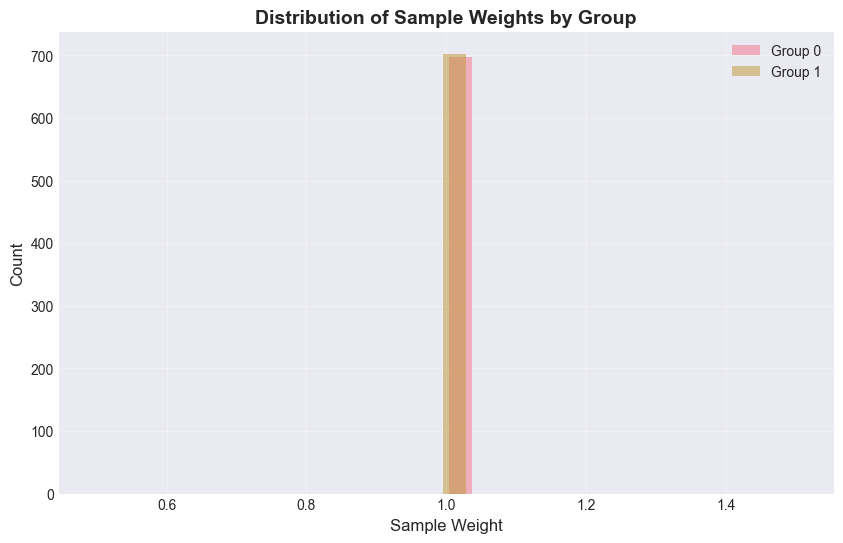


✅ BIAS MITIGATION COMPLETE


In [14]:
print("="*70)
print("STEP 3: BIAS MITIGATION")
print("="*70)

mitigation_method = config['bias_mitigation']['method']
print(f"\n🔧 Applying mitigation: {mitigation_method}")

if mitigation_method == 'reweighting':
    # Instance reweighting
    reweighter = InstanceReweighting(**config['bias_mitigation'].get('params', {}))
    X_train_mit, y_train_mit, sample_weights = reweighter.fit_transform(
        X_train, y_train, sensitive_features=s_train
    )
    
    print(f"\n📊 Reweighting Statistics:")
    print(f"  Weight range: [{sample_weights.min():.3f}, {sample_weights.max():.3f}]")
    print(f"  Mean weight: {sample_weights.mean():.3f}")
    print(f"  Std weight: {sample_weights.std():.3f}")
    
    # Visualize weights by group
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for group in [0, 1]:
        mask = s_train == group
        weights_group = sample_weights[mask]
        ax.hist(weights_group, bins=30, alpha=0.5, label=f'Group {group}')
    
    ax.set_xlabel('Sample Weight', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Distribution of Sample Weights by Group', fontsize=14, fontweight='bold')
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

elif mitigation_method == 'resampling':
    # Group resampling
    resampler = GroupBalancer(**config['bias_mitigation'].get('params', {}))
    X_train_mit, y_train_mit, s_train_mit = resampler.fit_resample(
        X_train, y_train, sensitive_features=s_train
    )
    sample_weights = None
    s_train = s_train_mit  # Update sensitive features after resampling
    
    print(f"\n📊 Resampling Statistics:")
    print(f"  Original size: {len(X_train)}")
    print(f"  New size: {len(X_train_mit)}")
    
else:
    # No mitigation
    X_train_mit = X_train
    y_train_mit = y_train
    sample_weights = None
    print("  No mitigation applied")

print(f"\n{'='*70}")
print("✅ BIAS MITIGATION COMPLETE")
print(f"{'='*70}")

## 5. Step 4: Fair Model Training

Train model with fairness constraints using Fairlearn's reduction approach.

In [15]:
print("="*70)
print("STEP 4: FAIR MODEL TRAINING")
print("="*70)

use_constraints = config['training']['use_fairness_constraints']

if use_constraints:
    print(f"\n🎓 Training with fairness constraints")
    print(f"  Constraint: {config['training']['constraint_type']}")
    print(f"  Epsilon: {config['training']['eps']}")
    
    # Train with fairness constraints
    fair_model = ReductionsWrapper(
        base_estimator=LogisticRegression(random_state=42, max_iter=1000),
        constraint=config['training']['constraint_type'],
        eps=config['training']['eps']
    )
    
    fair_model.fit(
        X_train_mit, 
        y_train_mit, 
        sensitive_features=s_train
    )
    
else:
    print(f"\n🎓 Training with sample weights (no constraints)")
    
    # Train with sample weights
    fair_model = LogisticRegression(random_state=42, max_iter=1000)
    fair_model.fit(
        X_train_mit, 
        y_train_mit, 
        sample_weight=sample_weights
    )

# Predictions
y_pred_fair = fair_model.predict(X_test)
fair_accuracy = accuracy_score(y_test, y_pred_fair)

print(f"\n📊 Fair Model Performance:")
print(f"  Test Accuracy: {fair_accuracy:.4f}")
print(f"  Accuracy change: {fair_accuracy - baseline_accuracy:+.4f}")

print(f"\n{'='*70}")
print("✅ FAIR MODEL TRAINING COMPLETE")
print(f"{'='*70}")

STEP 4: FAIR MODEL TRAINING

🎓 Training with sample weights (no constraints)

📊 Fair Model Performance:
  Test Accuracy: 0.9917
  Accuracy change: +0.0000

✅ FAIR MODEL TRAINING COMPLETE


## 6. Step 5: Final Validation

Measure fairness of the mitigated model and compare to baseline.

In [16]:
print("="*70)
print("STEP 5: FINAL VALIDATION")
print("="*70)

# Measure fairness of mitigated model
fair_fairness = analyzer.compute_all_metrics(
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=s_test,
    threshold=config['fairness_threshold'],
    compute_ci=True
)

print(f"\n⚖️  Mitigated Model Fairness Metrics:")
print("-" * 70)

fair_summary = []
for metric_name, result in fair_fairness.items():
    status = '✅ FAIR' if result.is_fair else '❌ UNFAIR'
    fair_summary.append({
        'Metric': metric_name.replace('_', ' ').title(),
        'Value': f"{result.value:.4f}",
        'Threshold': result.threshold,
        '95% CI': f"[{result.confidence_interval[0]:.4f}, {result.confidence_interval[1]:.4f}]",
        'Status': status
    })

fair_df = pd.DataFrame(fair_summary)
print(fair_df.to_string(index=False))

# Overall assessment
all_fair = all(r.is_fair for r in fair_fairness.values())
print(f"\n{'='*70}")
if all_fair:
    print("✅ MITIGATED MODEL: ALL METRICS PASSED")
else:
    print("⚠️  MITIGATED MODEL: SOME METRICS STILL UNFAIR")
    print("   → Consider stronger mitigation or different strategy")
print(f"{'='*70}")

STEP 5: FINAL VALIDATION
2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:24,151 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:24,155 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:24,161 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:26:24,166 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24,171 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:24,175 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158


2026-01-16 19:26:24,179 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:24,184 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:24,188 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:24,193 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:24,197 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:24,202 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:24,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:24,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0268


2026-01-16 19:26:24,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0268


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:24,223 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:24,227 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:24,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:24,234 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0176


2026-01-16 19:26:24,242 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0176


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-16 19:26:24,246 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:24,251 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:24,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:24,266 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:24,268 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:24,272 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:24,278 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:26:24,300 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:24,306 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0160


2026-01-16 19:26:24,311 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0160


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:24,317 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0227


2026-01-16 19:26:24,323 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0227


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-16 19:26:24,327 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:24,332 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:24,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:24,341 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:24,345 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:24,349 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:26:24,356 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:24,360 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24,368 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:24,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:24,377 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:26:24,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:24,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:24,392 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:24,396 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:24,401 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:24,405 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:24,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:24,413 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:24,418 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:24,423 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:24,428 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:24,432 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:24,437 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24,441 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:24,446 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:24,450 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0178


2026-01-16 19:26:24,454 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0178


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24,458 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-16 19:26:24,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:24,467 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:26:24,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:24,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:24,481 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:24,485 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:24,489 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:24,493 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:24,497 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-16 19:26:24,501 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:24,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:24,510 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:26:24,514 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:24,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:24,523 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0179


2026-01-16 19:26:24,528 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0179


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:24,534 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:24,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:24,559 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:24,567 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:24,571 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:24,576 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:24,580 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:24,584 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:24,588 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:24,601 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:24,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:24,610 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:24,615 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:24,619 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:24,623 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:24,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:24,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:24,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:24,639 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:24,643 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24,647 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:24,651 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:24,654 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:24,658 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:24,662 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:24,670 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-16 19:26:24,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:24,679 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:24,682 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:24,687 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24,691 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:24,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:24,699 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:24,703 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:24,707 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:24,710 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:24,715 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:24,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:24,723 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:26:24,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:24,731 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:24,738 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:24,742 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:24,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:24,752 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:24,756 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:24,762 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:24,767 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:24,771 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:24,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:24,787 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:26:24,795 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:24,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:24,807 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:24,812 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:26:24,816 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:26:24,824 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:24,829 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:24,834 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:24,838 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:26:24,842 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0157


2026-01-16 19:26:24,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0157


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:24,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-16 19:26:24,857 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:24,862 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:24,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:24,871 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:26:24,876 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0165


2026-01-16 19:26:24,880 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0165


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:24,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:24,891 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:24,896 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-16 19:26:24,901 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:24,905 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:24,909 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:24,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-16 19:26:24,923 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:24,931 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:24,938 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:26:24,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:24,949 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:24,953 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:24,957 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:24,962 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0213


2026-01-16 19:26:24,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0213


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:24,970 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:24,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:24,979 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:24,984 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:24,988 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:24,992 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:24,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:25,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:25,006 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:25,012 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:25,018 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:25,023 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:25,027 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:25,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:25,036 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:25,041 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:25,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:25,051 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:25,056 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25,060 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:25,064 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:25,069 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:25,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-16 19:26:25,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25,081 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:26:25,086 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:25,090 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:25,094 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:26:25,099 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:25,103 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:25,108 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:26:25,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:25,118 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:25,123 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25,128 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:25,132 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:25,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:25,141 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:25,146 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:25,151 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:25,156 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:25,161 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:25,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:25,170 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:25,175 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-16 19:26:25,181 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:25,186 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:25,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:25,196 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:25,200 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:25,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:25,209 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:25,213 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:25,218 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:26:25,222 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:25,227 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:25,233 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:25,237 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:25,242 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:26:25,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25,253 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-16 19:26:25,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:25,262 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:25,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:25,271 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:25,276 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:25,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:25,284 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:25,289 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:25,293 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:25,299 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0184


2026-01-16 19:26:25,303 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0184


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:25,316 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:25,320 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:25,325 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25,329 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25,334 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-16 19:26:25,340 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:26:25,345 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:25,349 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:25,354 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25,360 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-16 19:26:25,366 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:25,370 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:26:25,375 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:25,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:25,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:26:25,392 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:26:25,396 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:26:25,400 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:25,406 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:25,411 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0224


2026-01-16 19:26:25,415 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0224


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:25,421 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:26:25,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:25,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:26:25,435 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:26:25,438 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:25,441 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-16 19:26:25,447 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:26:25,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:25,458 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25,463 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:25,469 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:25,474 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:25,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:26:25,487 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:25,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:25,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25,501 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:25,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:26:25,509 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-16 19:26:25,513 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:25,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0210


2026-01-16 19:26:25,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0210


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:25,526 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:26:25,534 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:25,540 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:25,545 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:25,549 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:26:25,555 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:25,562 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:25,567 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:25,571 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-16 19:26:25,575 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:25,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:25,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:25,593 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:25,598 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:25,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:25,608 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:25,613 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:25,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:26:25,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:25,640 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:25,644 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-16 19:26:25,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-16 19:26:25,655 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:25,659 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:25,663 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:25,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:25,683 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:25,687 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:25,696 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:26:25,706 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:25,710 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25,718 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:25,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:25,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:25,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:25,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:25,738 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25,742 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:26:25,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:25,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:26:25,756 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:25,760 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:25,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:25,770 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:25,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:25,780 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:26:25,784 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:25,791 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:25,796 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:25,800 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:25,804 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:25,809 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:25,813 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:25,818 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:25,823 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:25,827 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:25,831 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25,835 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:25,839 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:26:25,843 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:25,848 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:26:25,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:25,857 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:25,861 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:25,867 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:26:25,873 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-16 19:26:25,877 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:25,885 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:25,888 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:25,892 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:26:25,904 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:25,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:26:25,925 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:25,930 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:25,935 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:25,939 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:25,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:25,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0218


2026-01-16 19:26:25,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0218


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:25,960 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:25,964 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:25,970 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:25,975 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:25,980 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:25,984 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:25,989 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:26:25,995 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:26,001 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:26,006 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:26,011 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:26,015 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:26,019 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:26,024 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:26,029 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:26,035 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:26,039 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:26,043 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:26,049 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:26:26,054 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:26,058 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:26,063 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:26,067 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:26,072 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0186


2026-01-16 19:26:26,076 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0186


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:26,082 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:26,087 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:26:26,092 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:26,098 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:26,102 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:26,107 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:26,111 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:26:26,116 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:26:26,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:26,125 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:26:26,129 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:26,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:26,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:26,141 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:26,147 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:26,154 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:26,159 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:26,169 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:26,174 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:26,179 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:26,184 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:26,189 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:26,194 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:26,200 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:26,204 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:26,210 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:26,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:26:26,220 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:26:26,224 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:26,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:26,234 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:26,239 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:26,244 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:26:26,249 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:26,253 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:26,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:26,266 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:26,273 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:26,278 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:26:26,283 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:26,288 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26,292 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-16 19:26:26,296 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26,300 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:26:26,304 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:26,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:26,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:26,317 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:26:26,321 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:26,325 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-16 19:26:26,329 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:26,334 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26,338 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:26:26,342 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:26,347 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:26,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:26,356 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:26,361 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:26,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:26,370 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:26,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:26,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:26,384 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:26,388 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:26,393 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:26,398 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26,403 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:26,408 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:26,413 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:26,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:26:26,422 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:26,426 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:26,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:26,435 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:26:26,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:26,445 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:26,450 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:26:26,454 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26,458 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:26,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:26,467 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:26,473 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:26:26,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:26,483 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:26,487 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:26,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:26:26,501 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:26,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:26,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:26,533 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:26,538 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:26,543 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:26,549 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:26:26,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:26,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:26,565 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:26,568 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:26,572 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:26,576 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:26:26,581 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:26,586 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:26,591 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0182


2026-01-16 19:26:26,595 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0182


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:26,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26,604 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:26,608 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:26,613 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-16 19:26:26,621 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:26,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-16 19:26:26,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:26:26,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:26,639 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:26:26,644 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:26,657 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:26,663 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:26:26,670 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:26,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:26,679 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:26,683 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:26,687 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:26,692 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:26,697 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:26,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:26,704 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:26,708 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:26,713 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:26:26,717 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0120


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26,721 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:26,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:26,731 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:26,735 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:26,739 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:26,743 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:26,748 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:26,752 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:26,757 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:26,762 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:26,766 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:26:26,771 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:26,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26,779 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26,784 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:26,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:26:26,793 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26,797 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0113


2026-01-16 19:26:26,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0113


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:26,809 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:26,814 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:26,818 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:26,822 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:26,827 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:26,831 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0187


2026-01-16 19:26:26,836 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0187


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:26,841 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:26:26,846 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:26,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:26,855 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:26,860 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:26:26,865 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:26,872 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:26:26,884 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:26,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:26,894 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:26:26,898 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:26,902 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-16 19:26:26,906 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-16 19:26:26,911 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:26,915 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0216


2026-01-16 19:26:26,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0216


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:26,929 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:26,934 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:26,938 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:26,943 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:26,948 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:26,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:26,960 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:26,964 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:26,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:26,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:26,978 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:26:26,982 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:26,987 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:26:26,992 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:26:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:26,996 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27,000 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:27,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27,009 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:27,016 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:27,063 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27,074 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:27,079 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:26:27,084 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:27,088 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:27,093 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:27,099 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:27,103 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:26:27,106 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:27,113 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:27,118 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:27,122 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:27,127 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:26:27,131 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:27,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:27,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:27,163 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-16 19:26:27,167 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:27,172 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:27,176 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:26:27,179 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:27,183 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:27,188 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:27,192 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:26:27,197 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27,200 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:27,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:27,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:27,218 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:27,222 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:26:27,227 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0142


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27,232 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:27,236 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:26:27,240 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:27,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:26:27,251 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27,255 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:27,260 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:26:27,266 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:27,271 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:26:27,276 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:26:27,281 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:27,285 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:27,289 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:27,295 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-16 19:26:27,299 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:27,303 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:27,310 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:27,316 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-16 19:26:27,321 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27,327 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:26:27,333 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0144


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:27,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:27,345 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:27,351 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:26:27,355 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:26:27,360 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:27,364 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0234


2026-01-16 19:26:27,375 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0234


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:27,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:27,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:27,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:27,394 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:27,399 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:27,403 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:27,407 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:27,412 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:27,422 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:26:27,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-16 19:26:27,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:27,435 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:26:27,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:27,444 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:27,449 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:27,454 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:27,459 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:27,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:27,467 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:26:27,472 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0124


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:27,476 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:27,481 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:27,485 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:27,489 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:27,495 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:27,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:26:27,504 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:27,508 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:27,513 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:26:27,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:27,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:27,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:27,536 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:27,541 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:26:27,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:27,551 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:27,555 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:27,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:27,566 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:27,571 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-16 19:26:27,575 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:27,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:27,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:27,589 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:27,594 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:27,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:27,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0109


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:27,612 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:27,616 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:26:27,622 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:26:27,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:26:27,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:27,636 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:26:27,640 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:27,645 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27,654 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:26:27,659 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:27,666 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:26:27,669 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0087


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:27,675 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:27,679 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:27,684 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:27,688 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:27,692 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:27,697 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:26:27,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:27,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:27,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:27,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:27,720 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:27,725 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:27,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:27,736 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:26:27,754 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:27,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:27,766 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0069


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:26:27,772 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:27,776 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27,782 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:27,786 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:26:27,791 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:27,796 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0036


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:26:27,800 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:27,804 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:27,808 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:27,812 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:26:27,818 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0013


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27,825 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:27,831 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:27,836 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:27,841 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:27,846 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-16 19:26:27,850 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:27,853 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:27,858 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:27,863 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:27,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:27,873 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:27,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-16 19:26:27,884 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:27,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:27,893 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:27,898 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:26:27,903 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:27,907 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:27,910 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:27,914 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:27,917 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:27,921 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0027


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0184


2026-01-16 19:26:27,929 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0184


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:27,934 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:27,938 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:27,943 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:27,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:27,951 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:26:27,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:27,960 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:26:27,964 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:27,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:27,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-16 19:26:27,979 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-16 19:26:27,984 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:27,988 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:27,993 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:27 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:27,996 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:28,001 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:28,004 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:28,008 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:28,013 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0067


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28,017 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:28,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:26:28,026 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:28,030 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:26:28,034 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:28,038 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28,043 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:28,048 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:28,053 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:28,057 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28,062 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:28,066 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:28,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:28,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:28,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:28,082 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:28,086 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28,091 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:28,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:28,099 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:26:28,104 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:28,108 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:28,116 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:28,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:28,127 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:28,130 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-16 19:26:28,166 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:28,170 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28,176 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:28,181 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:28,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:26:28,188 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:26:28,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:28,197 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:28,202 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:26:28,207 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:28,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:28,215 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28,219 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:28,225 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:28,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:26:28,237 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:28,241 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0089


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0169


2026-01-16 19:26:28,246 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0169


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28,292 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:28,296 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:28,302 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28,310 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:28,318 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:28,321 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0017


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:28,347 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:28,350 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-16 19:26:28,354 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:26:28,360 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:28,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:28,370 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:26:28,374 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:28,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:26:28,385 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:28,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:28,395 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:28,400 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:28,406 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:28,410 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:28,414 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:28,419 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:28,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-16 19:26:28,429 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:28,434 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:26:28,439 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:28,443 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:28,447 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:28,458 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:26:28,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:26:28,467 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:28,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:28,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-16 19:26:28,480 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:28,484 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0033


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:28,488 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:26:28,493 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:28,498 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:28,502 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:28,507 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:28,512 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:28,517 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:28,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0139


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:28,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:28,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0009


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:26:28,538 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:28,544 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:26:28,547 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0140


2026-01-16 19:26:28,552 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0140


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:28,556 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:28,561 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-16 19:26:28,566 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:28,570 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:26:28,576 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0081


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:28,581 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:28,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:28,589 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:28,593 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:26:28,597 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:28,602 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:26:28,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28,612 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:28,617 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:28,623 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:26:28,628 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0134


2026-01-16 19:26:28,632 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0134


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:28,638 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:28,643 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28,647 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:28,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:28,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28,660 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:26:28,664 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:28,669 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:28,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0179


2026-01-16 19:26:28,682 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0179


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:28,687 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:28,691 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:28,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0020


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:28,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:28,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:28,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:28,713 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:28,718 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:28,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:28,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:28,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:28,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:28,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28,741 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:28,745 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:26:28,749 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:28,753 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:28,756 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0122


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:26:28,761 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-16 19:26:28,765 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:28,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:28,772 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:26:28,776 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:28,780 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:28,784 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:28,787 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:28,791 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:28,795 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:28,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0061


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:26:28,807 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:28,811 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:28,816 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:28,820 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:28,824 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:28,824 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:26:28,832 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:28,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0015


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:28,840 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-16 19:26:28,845 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:26:28,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:28,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:28,855 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:28,859 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:26:28,862 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0083


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-16 19:26:28,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:28,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:28,876 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:28,880 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0063


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:26:28,884 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0115


2026-01-16 19:26:28,888 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0115


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:26:28,892 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:28,895 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0025


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:28,899 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-16 19:26:28,909 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:28,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0078


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:28,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:28,926 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0074


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:28,929 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:26:28,936 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:26:28,940 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:28,943 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:28,949 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0065


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:26:28,953 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-16 19:26:28,957 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:28,961 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:28,965 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:28,973 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158


2026-01-16 19:26:28,977 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:26:28,981 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:26:28,985 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:26:28,989 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:28,993 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0062


2026-01-16 19:26:28 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:28,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0060


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-16 19:26:29,009 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:29,016 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:29,020 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:29,023 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:26:29,028 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-16 19:26:29,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:29,036 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0031


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:29,040 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:29,045 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0032


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:26:29,048 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:29,053 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-16 19:26:29,058 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:29,062 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0066


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:29,067 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:29,072 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:29,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0168


2026-01-16 19:26:29,103 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0168


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:29,107 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:29,110 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0039


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:26:29,115 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0077


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:29,121 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:29,125 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:29,129 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:29,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:26:29,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:29,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:29,148 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:29,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:29,157 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:29,161 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:29,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:26:29,169 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0121


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:29,174 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:26:29,186 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:26:29,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,202 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:29,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0073)


2026-01-16 19:26:29,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0073)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:29,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0004)


2026-01-16 19:26:29,236 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0004)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0093)


2026-01-16 19:26:29,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0093)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:26:29,256 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,262 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:29,265 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0035)


2026-01-16 19:26:29,274 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0035)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,281 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:29,284 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:29,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,300 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0037)


2026-01-16 19:26:29,302 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0037)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:29,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0093)


2026-01-16 19:26:29,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0093)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,331 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:26:29,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0003)


2026-01-16 19:26:29,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0003)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,348 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:29,350 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:29,361 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0145)


2026-01-16 19:26:29,382 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0145)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:29,391 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0076)


2026-01-16 19:26:29,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0076)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0075)


2026-01-16 19:26:29,407 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0075)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:29,417 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:26:29,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0106)


2026-01-16 19:26:29,436 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0106)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:26:29,451 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0074)


2026-01-16 19:26:29,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0074)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:29,467 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,476 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:29,480 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0038)


2026-01-16 19:26:29,488 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0038)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:26:29,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0001)


2026-01-16 19:26:29,508 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0001)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0065)


2026-01-16 19:26:29,517 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0065)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,523 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0106)


2026-01-16 19:26:29,531 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0106)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:29,538 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0003)


2026-01-16 19:26:29,547 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0003)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0035)


2026-01-16 19:26:29,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0035)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:26:29,561 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,568 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:29,571 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0064)


2026-01-16 19:26:29,581 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0064)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:26:29,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0003)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0069)


2026-01-16 19:26:29,610 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0069)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:26:29,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0024)


2026-01-16 19:26:29,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0024)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0031)


2026-01-16 19:26:29,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0031)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0000)


2026-01-16 19:26:29,654 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:29,663 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0054)


2026-01-16 19:26:29,671 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0054)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,680 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0106)


2026-01-16 19:26:29,684 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0106)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0030)


2026-01-16 19:26:29,694 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0030)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0138)


2026-01-16 19:26:29,708 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0138)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0112)


2026-01-16 19:26:29,718 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0112)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0068)


2026-01-16 19:26:29,726 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0068)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0066)


2026-01-16 19:26:29,736 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0066)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0030)


2026-01-16 19:26:29,744 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0030)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:29,755 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0062)


2026-01-16 19:26:29,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0062)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0111)


2026-01-16 19:26:29,772 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0111)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0074)


2026-01-16 19:26:29,780 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0074)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0031)


2026-01-16 19:26:29,788 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0031)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0065)


2026-01-16 19:26:29,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0065)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0130)


2026-01-16 19:26:29,804 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0130)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:29,812 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:29,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:26:29,829 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0002)


2026-01-16 19:26:29,838 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0002)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:29,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0043)


2026-01-16 19:26:29,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0043)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29,863 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:29,865 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0000)


2026-01-16 19:26:29,875 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0060)


2026-01-16 19:26:29,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0060)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0101)


2026-01-16 19:26:29,893 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0101)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:29,902 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0061)


2026-01-16 19:26:29,911 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0061)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0005)


2026-01-16 19:26:29,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0005)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0108)


2026-01-16 19:26:29,929 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0108)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0110)


2026-01-16 19:26:29,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0110)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0072)


2026-01-16 19:26:29,948 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0072)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:29,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:26:29,965 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:26:29,973 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:26:29,982 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:26:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:29,991 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30,000 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:30,009 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0068)


2026-01-16 19:26:30,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0068)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:26:30,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:30,030 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0093)


2026-01-16 19:26:30,036 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0093)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0015)


2026-01-16 19:26:30,044 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0015)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:30,054 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0006)


2026-01-16 19:26:30,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0006)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:30,072 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:26:30,081 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0098)


2026-01-16 19:26:30,090 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0098)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30,098 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0063)


2026-01-16 19:26:30,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0063)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30,116 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:26:30,125 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:26:30,134 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,140 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0068)


2026-01-16 19:26:30,142 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0068)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,149 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0104)


2026-01-16 19:26:30,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0104)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0071)


2026-01-16 19:26:30,170 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0071)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0100)


2026-01-16 19:26:30,178 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0100)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0032)


2026-01-16 19:26:30,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0032)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0037)


2026-01-16 19:26:30,194 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0037)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:26:30,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0041)


2026-01-16 19:26:30,215 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0041)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,221 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0032)


2026-01-16 19:26:30,225 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0032)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:26:30,233 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:30,243 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2222 (TPR: 0.2222, FPR: 0.0033)


2026-01-16 19:26:30,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2222 (TPR: 0.2222, FPR: 0.0033)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0030)


2026-01-16 19:26:30,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0030)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:30,271 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0003)


2026-01-16 19:26:30,281 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0003)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0061)


2026-01-16 19:26:30,289 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0061)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0063)


2026-01-16 19:26:30,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0063)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,305 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:30,309 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:30,317 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,323 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0068)


2026-01-16 19:26:30,325 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0068)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0095)


2026-01-16 19:26:30,334 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0095)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0038)


2026-01-16 19:26:30,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0038)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:26:30,352 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0071)


2026-01-16 19:26:30,362 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0071)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,369 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:26:30,371 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:30,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8889 (TPR: 0.8889, FPR: 0.0033)


2026-01-16 19:26:30,390 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8889 (TPR: 0.8889, FPR: 0.0033)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,395 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:30,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:26:30,409 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:30,418 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:30,426 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0025)


2026-01-16 19:26:30,433 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0025)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:26:30,440 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0067)


2026-01-16 19:26:30,448 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0067)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0101)


2026-01-16 19:26:30,454 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0101)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:26:30,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,469 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0037)


2026-01-16 19:26:30,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0037)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:26:30,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,494 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:26:30,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:30,507 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0123)


2026-01-16 19:26:30,514 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0123)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,520 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:30,523 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0002)


2026-01-16 19:26:30,543 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0002)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:30,550 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:26:30,558 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:30,566 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0028)


2026-01-16 19:26:30,574 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0028)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30,584 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,590 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:30,592 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:30,600 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0001)


2026-01-16 19:26:30,608 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0001)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,614 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:26:30,614 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:30,624 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:26:30,648 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:30,656 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0024)


2026-01-16 19:26:30,665 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0024)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0100)


2026-01-16 19:26:30,671 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0100)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0000)


2026-01-16 19:26:30,680 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0110)


2026-01-16 19:26:30,689 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0110)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0042)


2026-01-16 19:26:30,692 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0042)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:26:30,701 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:30,707 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0001)


2026-01-16 19:26:30,711 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0001)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:30,717 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:30,725 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,731 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:26:30,733 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0036)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0001)


2026-01-16 19:26:30,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0001)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0005)


2026-01-16 19:26:30,749 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0005)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0053)


2026-01-16 19:26:30,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0053)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0037)


2026-01-16 19:26:30,766 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0037)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:26:30,774 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0030)


2026-01-16 19:26:30,783 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0030)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:30,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30,799 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0069)


2026-01-16 19:26:30,809 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0069)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0003)


2026-01-16 19:26:30,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0003)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0026)


2026-01-16 19:26:30,826 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0026)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0026)


2026-01-16 19:26:30,834 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0026)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:26:30,844 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0102)


2026-01-16 19:26:30,852 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0102)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,858 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0076)


2026-01-16 19:26:30,860 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0076)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0003)


2026-01-16 19:26:30,871 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0003)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:30,876 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:26:30,884 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0037)


2026-01-16 19:26:30,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0037)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0110)


2026-01-16 19:26:30,905 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0110)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,911 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:30,915 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:26:30,925 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:30,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30,944 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:30,947 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0102)


2026-01-16 19:26:30,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0102)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0002 (TPR: 0.0000, FPR: 0.0002)


2026-01-16 19:26:30,967 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0002 (TPR: 0.0000, FPR: 0.0002)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0040)


2026-01-16 19:26:30,978 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0040)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:30,987 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0077)


2026-01-16 19:26:30,997 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0077)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0001)


2026-01-16 19:26:31,006 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0001)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0063)


2026-01-16 19:26:31,015 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0063)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0012)


2026-01-16 19:26:31,024 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0012)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0000)


2026-01-16 19:26:31,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:31,043 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:26:31,053 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,059 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0000)


2026-01-16 19:26:31,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:31,072 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:31,080 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:31,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0030)


2026-01-16 19:26:31,098 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0030)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0025)


2026-01-16 19:26:31,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0025)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0001)


2026-01-16 19:26:31,116 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0001)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,122 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:31,124 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:31,133 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:26:31,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:31,153 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0096)


2026-01-16 19:26:31,163 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0096)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0002)


2026-01-16 19:26:31,171 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0002)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0032)


2026-01-16 19:26:31,180 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0032)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:31,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:31,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0001)


2026-01-16 19:26:31,212 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0001)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0036)


2026-01-16 19:26:31,221 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0036)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:31,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,237 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:31,239 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0009)


2026-01-16 19:26:31,250 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0009)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:31,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0037)


2026-01-16 19:26:31,270 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0037)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:31,280 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:26:31,289 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:31,299 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:31,307 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0101)


2026-01-16 19:26:31,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0101)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0031)


2026-01-16 19:26:31,327 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0031)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0063)


2026-01-16 19:26:31,336 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0063)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0008)


2026-01-16 19:26:31,346 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0008)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0003 (TPR: 0.0000, FPR: 0.0003)


2026-01-16 19:26:31,355 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0003 (TPR: 0.0000, FPR: 0.0003)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:31,364 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:31,374 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:31,383 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0034)


2026-01-16 19:26:31,393 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0034)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:31,402 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0061)


2026-01-16 19:26:31,411 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0061)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0001)


2026-01-16 19:26:31,420 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0001)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,428 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0110)


2026-01-16 19:26:31,429 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0110)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0074)


2026-01-16 19:26:31,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0074)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,447 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:31,450 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0073)


2026-01-16 19:26:31,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0073)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,468 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:31,471 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:31,480 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:26:31,493 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0028)


2026-01-16 19:26:31,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0028)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:31,516 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0003)


2026-01-16 19:26:31,524 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0003)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:31,533 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0062)


2026-01-16 19:26:31,544 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0062)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:31,553 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0028)


2026-01-16 19:26:31,562 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0028)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0068)


2026-01-16 19:26:31,570 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0068)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:26:31,578 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0037)


2026-01-16 19:26:31,588 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0037)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:31,597 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:31,600 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0102)


2026-01-16 19:26:31,605 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0102)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0002)


2026-01-16 19:26:31,613 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0002)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0075)


2026-01-16 19:26:31,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0075)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:26:31,642 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,647 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0104 (TPR: 0.0000, FPR: 0.0104)


2026-01-16 19:26:31,649 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0104 (TPR: 0.0000, FPR: 0.0104)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0034)


2026-01-16 19:26:31,658 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0034)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,666 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:31,668 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0183)


2026-01-16 19:26:31,676 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0183)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:26:31,684 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0066)


2026-01-16 19:26:31,694 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0066)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:31,699 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0063)


2026-01-16 19:26:31,705 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0063)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0034)


2026-01-16 19:26:31,714 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0034)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:31,722 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:31,730 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:31,738 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0039)


2026-01-16 19:26:31,747 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0039)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0000, FPR: 0.0070)


2026-01-16 19:26:31,755 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0000, FPR: 0.0070)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0034)


2026-01-16 19:26:31,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0034)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0038)


2026-01-16 19:26:31,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0038)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0067)


2026-01-16 19:26:31,781 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0067)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0068)


2026-01-16 19:26:31,788 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0068)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31,797 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0137)


2026-01-16 19:26:31,798 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0137)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0036)


2026-01-16 19:26:31,806 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0036)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0042)


2026-01-16 19:26:31,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0042)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0103)


2026-01-16 19:26:31,822 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0103)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:26:31,831 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0025)


2026-01-16 19:26:31,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0025)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:31,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:31,855 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:31,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:31,872 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0097)


2026-01-16 19:26:31,881 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0097)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:31,891 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:31,899 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:26:31,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:26:31,915 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0007)


2026-01-16 19:26:31,924 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0007)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:31,933 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0009)


2026-01-16 19:26:31,939 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0009)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:26:31,951 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0037)


2026-01-16 19:26:31,959 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0037)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0001)


2026-01-16 19:26:31,966 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0001)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0093)


2026-01-16 19:26:31,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0093)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0032)


2026-01-16 19:26:31,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0032)


2026-01-16 19:26:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0031)


2026-01-16 19:26:31,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0031)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,001 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:32,004 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:26:32,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0005)


2026-01-16 19:26:32,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0005)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0106)


2026-01-16 19:26:32,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0106)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0063)


2026-01-16 19:26:32,043 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0063)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0060)


2026-01-16 19:26:32,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0060)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6154 (TPR: 0.6154, FPR: 0.0035)


2026-01-16 19:26:32,059 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6154 (TPR: 0.6154, FPR: 0.0035)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:26:32,069 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,075 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:26:32,077 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0000, FPR: 0.0071)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,084 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0076)


2026-01-16 19:26:32,086 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0076)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0072)


2026-01-16 19:26:32,097 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0072)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0110)


2026-01-16 19:26:32,104 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0110)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0027)


2026-01-16 19:26:32,113 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0027)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:26:32,122 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:26:32,130 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0004)


2026-01-16 19:26:32,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0004)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:32,147 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0000)


2026-01-16 19:26:32,154 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,160 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:32,162 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,170 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:26:32,172 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:32,181 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:32,188 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0068)


2026-01-16 19:26:32,197 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0068)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,203 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3000 (TPR: 0.3000, FPR: 0.0036)


2026-01-16 19:26:32,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3000 (TPR: 0.3000, FPR: 0.0036)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:26:32,216 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:32,224 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:26:32,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,238 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32,240 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0009)


2026-01-16 19:26:32,251 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0009)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0041)


2026-01-16 19:26:32,258 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0041)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0037)


2026-01-16 19:26:32,268 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0037)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0067)


2026-01-16 19:26:32,276 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0067)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:32,285 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0072)


2026-01-16 19:26:32,293 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0072)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0008)


2026-01-16 19:26:32,301 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0008)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0110)


2026-01-16 19:26:32,310 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0110)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:32,315 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:32,321 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:32,329 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:32,338 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32,349 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:32,358 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,364 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:32,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:26:32,377 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:32,387 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,393 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:32,397 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:26:32,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:32,414 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0075)


2026-01-16 19:26:32,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0075)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0068)


2026-01-16 19:26:32,433 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0068)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0104)


2026-01-16 19:26:32,442 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0104)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32,451 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0081)


2026-01-16 19:26:32,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0081)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:32,470 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0032)


2026-01-16 19:26:32,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0042)


2026-01-16 19:26:32,510 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0042)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:32,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0026)


2026-01-16 19:26:32,527 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0026)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0038)


2026-01-16 19:26:32,535 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0038)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0069)


2026-01-16 19:26:32,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0069)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,552 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:32,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3000 (TPR: 0.3000, FPR: 0.0043)


2026-01-16 19:26:32,569 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3000 (TPR: 0.3000, FPR: 0.0043)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:32,579 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:32,588 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,594 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0074)


2026-01-16 19:26:32,596 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0074)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0063)


2026-01-16 19:26:32,605 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0063)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0084)


2026-01-16 19:26:32,621 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0084)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:32,630 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,636 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:32,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:26:32,654 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0006)


2026-01-16 19:26:32,664 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0006)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:32,682 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,687 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0068)


2026-01-16 19:26:32,698 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0068)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:32,706 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0014)


2026-01-16 19:26:32,715 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0014)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:32,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:32,733 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0034)


2026-01-16 19:26:32,741 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,747 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0071)


2026-01-16 19:26:32,748 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0071)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:26:32,765 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0070)


2026-01-16 19:26:32,782 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0070)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:26:32,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0093)


2026-01-16 19:26:32,800 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0093)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0024)


2026-01-16 19:26:32,808 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0024)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8889 (TPR: 0.8889, FPR: 0.0030)


2026-01-16 19:26:32,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8889 (TPR: 0.8889, FPR: 0.0030)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:32,826 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:32,836 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,844 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:32,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:26:32,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:26:32,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:26:32,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0024)


2026-01-16 19:26:32,886 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0024)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:32,894 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,900 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0031)


2026-01-16 19:26:32,902 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0031)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0032)


2026-01-16 19:26:32,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0032)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:32,922 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:26:32,931 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32,939 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:32,949 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:26:32,958 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32,966 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0064)


2026-01-16 19:26:32,969 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0064)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:32,984 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:26:32,993 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:33,002 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0037)


2026-01-16 19:26:33,012 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0037)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:33,021 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0001)


2026-01-16 19:26:33,030 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0001)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0106)


2026-01-16 19:26:33,038 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0106)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33,047 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0101)


2026-01-16 19:26:33,050 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0101)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:26:33,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0069)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:33,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0068)


2026-01-16 19:26:33,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0068)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:33,096 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:33,106 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:33,115 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0007)


2026-01-16 19:26:33,125 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0007)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:26:33,133 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0039)


2026-01-16 19:26:33,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0039)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:26:33,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0005)


2026-01-16 19:26:33,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0005)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:33,174 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0000, FPR: 0.0070)


2026-01-16 19:26:33,186 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0000, FPR: 0.0070)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0000)


2026-01-16 19:26:33,194 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0073)


2026-01-16 19:26:33,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0073)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0003)


2026-01-16 19:26:33,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0003)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0005)


2026-01-16 19:26:33,225 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0005)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0004)


2026-01-16 19:26:33,236 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0004)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:33,244 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0037)


2026-01-16 19:26:33,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0037)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0070)


2026-01-16 19:26:33,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0070)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0004)


2026-01-16 19:26:33,266 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0004)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33,275 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0000)


2026-01-16 19:26:33,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33,283 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:33,283 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0067)


2026-01-16 19:26:33,296 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0067)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0025)


2026-01-16 19:26:33,304 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0025)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0067)


2026-01-16 19:26:33,316 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0067)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:33,324 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0003)


2026-01-16 19:26:33,334 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0003)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0037)


2026-01-16 19:26:33,340 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0037)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0066)


2026-01-16 19:26:33,349 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0066)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:33,356 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0031)


2026-01-16 19:26:33,365 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0031)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0105)


2026-01-16 19:26:33,372 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0105)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:33,381 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0033)


2026-01-16 19:26:33,395 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8750 (TPR: 0.8750, FPR: 0.0033)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:26:33,404 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:26:33,413 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:26:33,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:26:33,433 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:33,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0106)


2026-01-16 19:26:33,449 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0106)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:33,459 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0087)


2026-01-16 19:26:33,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0087)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0065)


2026-01-16 19:26:33,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0065)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:33,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:33,495 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:33,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0000)


2026-01-16 19:26:33,513 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:33,521 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:26:33,530 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0070)


2026-01-16 19:26:33,538 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0070)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:33,546 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0072)


2026-01-16 19:26:33,554 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0072)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0033)


2026-01-16 19:26:33,561 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0033)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33,566 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:26:33,566 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:33,577 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33,584 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:33,584 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0005)


2026-01-16 19:26:33,596 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0005)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:33,604 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:26:33,610 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:26:33,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:33,627 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0104)


2026-01-16 19:26:33,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0104)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0065)


2026-01-16 19:26:33,642 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0065)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0029)


2026-01-16 19:26:33,652 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0029)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33,655 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:33,655 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4545 (TPR: 0.4545, FPR: 0.0008)


2026-01-16 19:26:33,670 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4545 (TPR: 0.4545, FPR: 0.0008)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:33,679 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0118)


2026-01-16 19:26:33,686 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0118)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0001 (TPR: 0.0000, FPR: 0.0001)


2026-01-16 19:26:33,694 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0001 (TPR: 0.0000, FPR: 0.0001)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0005)


2026-01-16 19:26:33,703 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0005)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0032)


2026-01-16 19:26:33,710 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0032)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:26:33,718 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0039)


2026-01-16 19:26:33,726 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0039)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:26:33,734 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0072)


2026-01-16 19:26:33,742 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0072)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:33,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:26:33,758 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:26:33,767 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:33,830 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:33,840 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0064)


2026-01-16 19:26:33,846 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0064)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:33,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0000)


2026-01-16 19:26:33,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0063)


2026-01-16 19:26:33,879 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0063)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:26:33,888 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:33,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0044)


2026-01-16 19:26:33,904 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0044)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0035)


2026-01-16 19:26:33,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0035)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0026)


2026-01-16 19:26:33,922 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0026)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33,928 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:33,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:33,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0002)


2026-01-16 19:26:33,952 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0002)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:33,958 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:26:33,964 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:26:33,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33,981 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:33,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0031)


2026-01-16 19:26:33,989 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0031)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:34,000 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:26:34,006 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0005)


2026-01-16 19:26:34,017 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0005)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0067)


2026-01-16 19:26:34,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0067)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:26:34,033 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0055)


2026-01-16 19:26:34,039 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0055)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0105)


2026-01-16 19:26:34,048 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0105)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0094)


2026-01-16 19:26:34,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0094)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0072)


2026-01-16 19:26:34,059 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0072)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:34,066 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,069 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0035)


2026-01-16 19:26:34,069 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,077 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0000, FPR: 0.0070)


2026-01-16 19:26:34,077 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0000, FPR: 0.0070)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0072)


2026-01-16 19:26:34,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0072)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0102)


2026-01-16 19:26:34,096 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0102)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0068)


2026-01-16 19:26:34,104 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0068)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:34,110 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0022)


2026-01-16 19:26:34,112 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0022)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:26:34,123 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0032)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:34,129 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0023)


2026-01-16 19:26:34,131 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0023)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:26:34,137 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0074)


2026-01-16 19:26:34,137 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0074)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0025)


2026-01-16 19:26:34,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0025)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:34,155 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0037)


2026-01-16 19:26:34,166 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0037)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0034)


2026-01-16 19:26:34,172 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0034)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:34,179 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0042)


2026-01-16 19:26:34,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0042)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0033)


2026-01-16 19:26:34,196 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0033)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:34,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0062)


2026-01-16 19:26:34,212 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0062)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:34,221 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,227 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:26:34,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0034)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,240 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:34,244 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:34,255 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:26:34,268 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0034)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0007)


2026-01-16 19:26:34,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0007)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:34,287 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0007)


2026-01-16 19:26:34,296 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0007)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:34,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:26:34,326 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0003)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0071)


2026-01-16 19:26:34,336 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0071)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:34,346 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0032)


2026-01-16 19:26:34,356 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0032)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0071)


2026-01-16 19:26:34,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0071)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:26:34,374 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0032)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:34,383 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:26:34,392 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0036)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0063)


2026-01-16 19:26:34,401 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1429 (TPR: 0.1429, FPR: 0.0063)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0061)


2026-01-16 19:26:34,411 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0061)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:34,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:26:34,429 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,437 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:34,440 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0000, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0000, FPR: 0.0011)


2026-01-16 19:26:34,449 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0000, FPR: 0.0011)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0097)


2026-01-16 19:26:34,458 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0097)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0008)


2026-01-16 19:26:34,467 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0008)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0002)


2026-01-16 19:26:34,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0002)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,484 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0071)


2026-01-16 19:26:34,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0071)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,494 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0038)


2026-01-16 19:26:34,496 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0038)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:34,505 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0042)


2026-01-16 19:26:34,514 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0042)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,521 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:34,522 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0069)


2026-01-16 19:26:34,532 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0069)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:34,540 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:26:34,549 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0004)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0027)


2026-01-16 19:26:34,559 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0027)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:26:34,569 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:34,578 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0031)


2026-01-16 19:26:34,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0031)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,596 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:34,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0034)


2026-01-16 19:26:34,608 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0034)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0009)


2026-01-16 19:26:34,618 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0009)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:26:34,628 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:34,636 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0003)


2026-01-16 19:26:34,649 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0003)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:34,659 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:34,669 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0030)


2026-01-16 19:26:34,678 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0030)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0071)


2026-01-16 19:26:34,686 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0071)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,693 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:34,694 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0068)


2026-01-16 19:26:34,705 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0068)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:34,714 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:34,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,729 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:34,731 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0066)


2026-01-16 19:26:34,741 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0066)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0023)


2026-01-16 19:26:34,750 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0023)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0033)


2026-01-16 19:26:34,759 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0033)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0109 (TPR: 0.0000, FPR: 0.0109)


2026-01-16 19:26:34,767 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0109 (TPR: 0.0000, FPR: 0.0109)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0006)


2026-01-16 19:26:34,776 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0006)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,783 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0069)


2026-01-16 19:26:34,787 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0069)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:34,795 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:34,803 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4615 (TPR: 0.4615, FPR: 0.0077)


2026-01-16 19:26:34,812 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4615 (TPR: 0.4615, FPR: 0.0077)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0000, FPR: 0.0063)


2026-01-16 19:26:34,820 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0000, FPR: 0.0063)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0095)


2026-01-16 19:26:34,840 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0095)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0049)


2026-01-16 19:26:34,866 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0049)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0037)


2026-01-16 19:26:34,874 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0037)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0110)


2026-01-16 19:26:34,882 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0110)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:26:34,892 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0005)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:26:34,900 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,906 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:34,910 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,918 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0075)


2026-01-16 19:26:34,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0075)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0027)


2026-01-16 19:26:34,932 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0027)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0000, FPR: 0.0067)


2026-01-16 19:26:34,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0000, FPR: 0.0067)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34,948 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:34,950 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0035)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0006)


2026-01-16 19:26:34,958 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0006)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0014)


2026-01-16 19:26:34,966 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0014)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:26:34,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6364 (TPR: 0.6364, FPR: 0.0072)


2026-01-16 19:26:34,983 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6364 (TPR: 0.6364, FPR: 0.0072)


2026-01-16 19:26:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:26:34,993 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0035)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0063)


2026-01-16 19:26:35,007 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0063)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0021 (TPR: 0.0000, FPR: 0.0021)


2026-01-16 19:26:35,021 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0021 (TPR: 0.0000, FPR: 0.0021)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0005)


2026-01-16 19:26:35,030 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0005)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35,040 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0037)


2026-01-16 19:26:35,048 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0037)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:35,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:35,068 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0063)


2026-01-16 19:26:35,074 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0063)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,084 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0105)


2026-01-16 19:26:35,087 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0105)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:26:35,097 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0032)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0031)


2026-01-16 19:26:35,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0031)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:35,117 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,123 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35,125 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0033)


2026-01-16 19:26:35,134 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:35,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0003)


2026-01-16 19:26:35,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0003)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,159 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:26:35,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0036)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:26:35,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0006)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:35,175 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0040)


2026-01-16 19:26:35,184 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0040)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0033)


2026-01-16 19:26:35,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0008)


2026-01-16 19:26:35,199 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0008)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:35,203 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0045)


2026-01-16 19:26:35,215 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0045)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0029)


2026-01-16 19:26:35,225 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0029)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0029)


2026-01-16 19:26:35,235 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0029)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:26:35,243 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:35,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:35,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:35,265 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:35,269 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:35,276 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0000)


2026-01-16 19:26:35,284 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,291 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:35,293 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,300 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:35,302 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,309 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0038)


2026-01-16 19:26:35,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0038)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0002)


2026-01-16 19:26:35,326 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0002)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0099)


2026-01-16 19:26:35,335 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0099)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0004)


2026-01-16 19:26:35,343 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0004)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0031)


2026-01-16 19:26:35,358 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0031)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:35,368 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:35,377 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0000, FPR: 0.0063)


2026-01-16 19:26:35,387 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0000, FPR: 0.0063)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:35,396 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0000, FPR: 0.0063)


2026-01-16 19:26:35,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0000, FPR: 0.0063)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:26:35,416 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0031)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:35,425 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0063)


2026-01-16 19:26:35,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0063)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:35,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0002)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0071)


2026-01-16 19:26:35,453 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0071)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,460 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:26:35,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0035)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,470 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35,472 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0063)


2026-01-16 19:26:35,480 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0063)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:35,489 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:35,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0100)


2026-01-16 19:26:35,508 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0100)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0067)


2026-01-16 19:26:35,516 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0067)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,523 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:35,526 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0035)


2026-01-16 19:26:35,534 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0035)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0040)


2026-01-16 19:26:35,543 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0040)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:35,553 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0035)


2026-01-16 19:26:35,561 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0035)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:26:35,569 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0002)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0035)


2026-01-16 19:26:35,577 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0035)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0001)


2026-01-16 19:26:35,586 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0001)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:26:35,596 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0063)


2026-01-16 19:26:35,607 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0063)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0037)


2026-01-16 19:26:35,615 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0037)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0006)


2026-01-16 19:26:35,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0006)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:35,626 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:35,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,640 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:35,642 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:35,650 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:26:35,657 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0063)


2026-01-16 19:26:35,664 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0063)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0036)


2026-01-16 19:26:35,674 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0036)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:35,683 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0031)


2026-01-16 19:26:35,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0031)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0062 (TPR: 0.0000, FPR: 0.0062)


2026-01-16 19:26:35,698 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0062 (TPR: 0.0000, FPR: 0.0062)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0028)


2026-01-16 19:26:35,707 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0028)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0032)


2026-01-16 19:26:35,715 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0032)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,721 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:26:35,724 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0025)


2026-01-16 19:26:35,733 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0025)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,739 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:35,741 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0105)


2026-01-16 19:26:35,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0105)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0098 (TPR: 0.0000, FPR: 0.0098)


2026-01-16 19:26:35,761 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0098 (TPR: 0.0000, FPR: 0.0098)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,768 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:26:35,781 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0035)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0041)


2026-01-16 19:26:35,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0041)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0000, FPR: 0.0070)


2026-01-16 19:26:35,802 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0000, FPR: 0.0070)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:26:35,809 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:35,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35,827 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:35,837 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:26:35,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:35,855 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0065)


2026-01-16 19:26:35,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0065)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0005)


2026-01-16 19:26:35,872 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0005)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,879 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:26:35,882 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0034)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0037)


2026-01-16 19:26:35,895 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0037)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:26:35,903 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0036)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0002)


2026-01-16 19:26:35,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0002)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:26:35,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:35,932 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:35,940 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:35,949 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:35,954 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0066)


2026-01-16 19:26:35,965 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0066)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35,971 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0036)


2026-01-16 19:26:35,974 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0036)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0022)


2026-01-16 19:26:35,981 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0022)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0065)


2026-01-16 19:26:35,989 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0065)


2026-01-16 19:26:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:35,998 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0033)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0031)


2026-01-16 19:26:36,008 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0031)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0073)


2026-01-16 19:26:36,017 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0073)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:36,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:36,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0035)


2026-01-16 19:26:36,042 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0035)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,049 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3000 (TPR: 0.3000, FPR: 0.0072)


2026-01-16 19:26:36,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3000 (TPR: 0.3000, FPR: 0.0072)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:36,077 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:26:36,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0000, FPR: 0.0111)


2026-01-16 19:26:36,093 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0000, FPR: 0.0111)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0071)


2026-01-16 19:26:36,103 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0071)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0040 (TPR: 0.0000, FPR: 0.0040)


2026-01-16 19:26:36,111 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0040 (TPR: 0.0000, FPR: 0.0040)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0066)


2026-01-16 19:26:36,119 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0066)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:36,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0091)


2026-01-16 19:26:36,146 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0091)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:26:36,153 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,159 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0034)


2026-01-16 19:26:36,162 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0034)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0072)


2026-01-16 19:26:36,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0072)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0008)


2026-01-16 19:26:36,181 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0008)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,187 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:36,189 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0072)


2026-01-16 19:26:36,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0072)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:36,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4545 (TPR: 0.4545, FPR: 0.0000)


2026-01-16 19:26:36,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4545 (TPR: 0.4545, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:36,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0004 (TPR: 0.0000, FPR: 0.0004)


2026-01-16 19:26:36,244 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0004 (TPR: 0.0000, FPR: 0.0004)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0102)


2026-01-16 19:26:36,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0102)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,259 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0068)


2026-01-16 19:26:36,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0068)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,268 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2222 (TPR: 0.2222, FPR: 0.0000)


2026-01-16 19:26:36,272 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2222 (TPR: 0.2222, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0027)


2026-01-16 19:26:36,281 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0027)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0009)


2026-01-16 19:26:36,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0009)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:26:36,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0071)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0007)


2026-01-16 19:26:36,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0007)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:36,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:26:36,327 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0033)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0031)


2026-01-16 19:26:36,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0031)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,344 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:26:36,346 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0045)


2026-01-16 19:26:36,357 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0045)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5833 (TPR: 0.5833, FPR: 0.0000)


2026-01-16 19:26:36,365 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5833 (TPR: 0.5833, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:36,374 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0002 (TPR: 0.0000, FPR: 0.0002)


2026-01-16 19:26:36,383 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0002 (TPR: 0.0000, FPR: 0.0002)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0076)


2026-01-16 19:26:36,392 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0076)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0027)


2026-01-16 19:26:36,401 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0027)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0000)


2026-01-16 19:26:36,409 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5556 (TPR: 0.5556, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0020)


2026-01-16 19:26:36,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0020)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,429 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0037)


2026-01-16 19:26:36,433 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0037)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0068)


2026-01-16 19:26:36,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0068)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,450 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:26:36,454 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0000, FPR: 0.0005)


2026-01-16 19:26:36,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0000, FPR: 0.0005)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:36,473 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0007)


2026-01-16 19:26:36,482 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0007)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:26:36,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0000, FPR: 0.0032)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:26:36,500 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:26:36,508 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0096)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0006)


2026-01-16 19:26:36,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0006)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0071)


2026-01-16 19:26:36,525 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0071)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:26:36,535 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0032)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0029)


2026-01-16 19:26:36,543 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0029)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0071)


2026-01-16 19:26:36,551 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0071)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,558 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:36,560 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0028)


2026-01-16 19:26:36,570 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0028)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0040)


2026-01-16 19:26:36,579 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0040)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,586 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:36,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,596 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0037 (TPR: 0.0000, FPR: 0.0037)


2026-01-16 19:26:36,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0037 (TPR: 0.0000, FPR: 0.0037)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0008)


2026-01-16 19:26:36,608 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0008)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:36,617 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0056)


2026-01-16 19:26:36,625 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0056)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:36,633 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,639 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0034)


2026-01-16 19:26:36,642 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0034)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0027)


2026-01-16 19:26:36,652 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0027)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,659 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0031)


2026-01-16 19:26:36,662 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0031)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:36,670 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:36,678 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,684 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0038)


2026-01-16 19:26:36,687 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0038)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0060 (TPR: 0.0000, FPR: 0.0060)


2026-01-16 19:26:36,696 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0060 (TPR: 0.0000, FPR: 0.0060)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:36,704 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:26:36,713 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0033)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:36,721 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:26:36,729 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0035)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0076)


2026-01-16 19:26:36,738 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0076)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0068)


2026-01-16 19:26:36,746 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0068)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0037)


2026-01-16 19:26:36,755 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0037)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:36,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:26:36,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,776 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0111)


2026-01-16 19:26:36,779 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0111)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:26:36,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2500 (TPR: 0.2500, FPR: 0.0034)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0002)


2026-01-16 19:26:36,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0002)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0069)


2026-01-16 19:26:36,804 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0069)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:26:36,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:36,822 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0096)


2026-01-16 19:26:36,831 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0096)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0035)


2026-01-16 19:26:36,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7778 (TPR: 0.7778, FPR: 0.0035)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0067)


2026-01-16 19:26:36,846 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0067)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:26:36,854 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0030)


2026-01-16 19:26:36,862 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0030)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:36,870 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0037)


2026-01-16 19:26:36,879 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0037)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,887 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:36,891 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0069)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0043)


2026-01-16 19:26:36,900 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0043)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,905 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0069 (TPR: 0.0000, FPR: 0.0069)


2026-01-16 19:26:36,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0069 (TPR: 0.0000, FPR: 0.0069)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:36,916 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0030)


2026-01-16 19:26:36,924 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0030)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36,932 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0071)


2026-01-16 19:26:36,934 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0071)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:36,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0000)


2026-01-16 19:26:36,951 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4444 (TPR: 0.4444, FPR: 0.0000)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0004)


2026-01-16 19:26:36,959 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0004)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:36,967 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0034)


2026-01-16 19:26:36,976 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0034)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:26:36,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0001)


2026-01-16 19:26:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:26:36,992 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0027)


2026-01-16 19:26:37,002 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0027)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0045 (TPR: 0.0000, FPR: 0.0045)


2026-01-16 19:26:37,010 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0045 (TPR: 0.0000, FPR: 0.0045)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:37,017 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:37,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:37,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0001)


2026-01-16 19:26:37,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0001)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:37,078 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:26:37,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0001)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:37,092 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0052)


2026-01-16 19:26:37,100 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0052)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:26:37,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0073)


2026-01-16 19:26:37,116 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0073)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0030)


2026-01-16 19:26:37,127 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8571 (TPR: 0.8571, FPR: 0.0030)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:37,135 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0055)


2026-01-16 19:26:37,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0055)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0034)


2026-01-16 19:26:37,157 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0034)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0021)


2026-01-16 19:26:37,165 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0021)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:26:37,174 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:26:37,181 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0071)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:37,190 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0044)


2026-01-16 19:26:37,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0044)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:37,221 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0070)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0069)


2026-01-16 19:26:37,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0069)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0032)


2026-01-16 19:26:37,238 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0028)


2026-01-16 19:26:37,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0028)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0010)


2026-01-16 19:26:37,256 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0010)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0003)


2026-01-16 19:26:37,264 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0003)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:26:37,272 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:37,281 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:26:37,289 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0040)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,295 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:26:37,297 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0000, FPR: 0.0036)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0072)


2026-01-16 19:26:37,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0072)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:37,315 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8889 (TPR: 0.8889, FPR: 0.0032)


2026-01-16 19:26:37,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8889 (TPR: 0.8889, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0007)


2026-01-16 19:26:37,330 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0007)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0000)


2026-01-16 19:26:37,338 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7000 (TPR: 0.7000, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:26:37,347 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0036)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0000, FPR: 0.0018)


2026-01-16 19:26:37,356 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0000, FPR: 0.0018)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:37,366 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0001)


2026-01-16 19:26:37,370 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0001)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,380 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:37,382 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:37,391 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0067)


2026-01-16 19:26:37,400 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0067)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0068)


2026-01-16 19:26:37,410 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0068)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,416 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:37,418 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0036)


2026-01-16 19:26:37,426 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0036)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,434 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:37,436 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,445 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:37,447 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:26:37,457 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0006)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,463 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:37,467 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0000, FPR: 0.0034)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0073)


2026-01-16 19:26:37,475 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0073)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0001)


2026-01-16 19:26:37,484 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0001)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0028)


2026-01-16 19:26:37,494 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0028)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,499 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0037)


2026-01-16 19:26:37,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0037)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0032)


2026-01-16 19:26:37,511 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6250 (TPR: 0.6250, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0035)


2026-01-16 19:26:37,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2857 (TPR: 0.2857, FPR: 0.0035)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:37,528 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:37,538 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:37,546 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0034)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0065)


2026-01-16 19:26:37,554 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0065)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6364 (TPR: 0.6364, FPR: 0.0036)


2026-01-16 19:26:37,562 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6364 (TPR: 0.6364, FPR: 0.0036)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0071)


2026-01-16 19:26:37,572 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0071)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0031)


2026-01-16 19:26:37,580 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0031)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0006)


2026-01-16 19:26:37,588 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0006)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0037)


2026-01-16 19:26:37,596 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0037)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:37,606 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0064)


2026-01-16 19:26:37,614 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0064)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0003)


2026-01-16 19:26:37,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0003)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0028)


2026-01-16 19:26:37,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0028)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:26:37,639 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0034)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:26:37,647 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0031)


2026-01-16 19:26:37,657 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0031)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:37,667 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0034)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0064)


2026-01-16 19:26:37,675 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0064)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0001)


2026-01-16 19:26:37,682 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0001)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,690 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:26:37,692 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0000, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,698 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:37,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0108)


2026-01-16 19:26:37,710 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0108)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,718 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0035)


2026-01-16 19:26:37,720 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1667 (TPR: 0.1667, FPR: 0.0035)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0068)


2026-01-16 19:26:37,731 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0068)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:37,735 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:37,739 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0043)


2026-01-16 19:26:37,749 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0043)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:26:37,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0002)


2026-01-16 19:26:37,767 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0002)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:37,775 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0042)


2026-01-16 19:26:37,784 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0042)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0033)


2026-01-16 19:26:37,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0078)


2026-01-16 19:26:37,801 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0078)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0094)


2026-01-16 19:26:37,810 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0094)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0105)


2026-01-16 19:26:37,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0105)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0105)


2026-01-16 19:26:37,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0105)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:37,836 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:26:37,844 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0065)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:37,852 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0066)


2026-01-16 19:26:37,860 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0066)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,866 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:37,868 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:26:37,878 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0035)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0002)


2026-01-16 19:26:37,888 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8333 (TPR: 0.8333, FPR: 0.0002)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:37,902 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:37,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:26:37,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0033)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0107)


2026-01-16 19:26:37,930 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0107)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:37,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:26:37,950 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:37,958 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:26:37,966 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0004)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:37,976 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0066)


2026-01-16 19:26:37,984 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0066)


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37,990 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:37,992 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0028)


2026-01-16 19:26:38,002 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0028)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:26:38,010 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0001)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,018 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0000)


2026-01-16 19:26:38,020 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3750 (TPR: 0.3750, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:38,030 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0036)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,038 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:38,040 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0037)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0001 (TPR: 0.0000, FPR: 0.0001)


2026-01-16 19:26:38,050 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0001 (TPR: 0.0000, FPR: 0.0001)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0008)


2026-01-16 19:26:38,058 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0008)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,066 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:38,068 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:38,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0003)


2026-01-16 19:26:38,086 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0003)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0038)


2026-01-16 19:26:38,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0038)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:38,104 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0034)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:26:38,114 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0036)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0099)


2026-01-16 19:26:38,122 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0099)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:38,132 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0031)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0051)


2026-01-16 19:26:38,142 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0051)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0005)


2026-01-16 19:26:38,150 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5714 (TPR: 0.5714, FPR: 0.0005)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0048)


2026-01-16 19:26:38,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0048)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:26:38,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0004)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0067)


2026-01-16 19:26:38,176 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0067)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,184 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:38,186 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:26:38,196 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8000 (TPR: 0.8000, FPR: 0.0036)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:26:38,206 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0032)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0137)


2026-01-16 19:26:38,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0137)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0091)


2026-01-16 19:26:38,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0091)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,226 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0036)


2026-01-16 19:26:38,228 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0036)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0071)


2026-01-16 19:26:38,238 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0071)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:38,244 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0035)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:38,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0042)


2026-01-16 19:26:38,264 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0042)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0068)


2026-01-16 19:26:38,274 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0068)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0001)


2026-01-16 19:26:38,283 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0001)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0010)


2026-01-16 19:26:38,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0010)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0070)


2026-01-16 19:26:38,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0070)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0038)


2026-01-16 19:26:38,307 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0038)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,311 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0037)


2026-01-16 19:26:38,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.2000 (TPR: 0.2000, FPR: 0.0037)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0068)


2026-01-16 19:26:38,321 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7143 (TPR: 0.7143, FPR: 0.0068)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:38,329 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0035)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:38,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4000 (TPR: 0.4000, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:38,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:26:38,353 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0072)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:38,361 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:26:38,369 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0031)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:38,377 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.5000 (TPR: 0.5000, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0029)


2026-01-16 19:26:38,384 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0029)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:38,392 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:38,402 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.4286 (TPR: 0.4286, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8182 (TPR: 0.8182, FPR: 0.0008)


2026-01-16 19:26:38,410 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.8182 (TPR: 0.8182, FPR: 0.0008)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0030)


2026-01-16 19:26:38,419 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0030)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:38,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0037)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:38,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.3333 (TPR: 0.3333, FPR: 0.0000)


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38,444 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,452 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38,459 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38,467 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38,470 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38,482 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:38,490 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38,498 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,503 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38,506 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:38,512 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:38,520 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:38,528 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38,536 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:38,543 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,549 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4545


2026-01-16 19:26:38,551 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4545


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,559 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38,567 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,573 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38,573 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:38,585 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38,592 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38,602 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:38,602 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,616 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:38,618 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,626 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:38,666 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:38,674 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38,683 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38,691 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38,700 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:38,722 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,730 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,736 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:38,738 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:38,747 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38,755 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:38,765 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:38,771 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,778 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:38,780 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:38,786 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38,796 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38,812 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,818 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:38,830 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:38,834 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,834 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,842 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:38,845 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:38,853 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:38,859 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38,863 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38,867 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:38,873 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:38,877 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:38,883 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38,886 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38,895 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:38,900 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38,900 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,909 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:38,915 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:38,917 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,917 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,925 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:38,930 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,936 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38,940 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:38,949 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,953 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:38,960 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38,969 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38,975 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:38,981 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:38,985 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38,989 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:38 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:38,991 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,000 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:39,005 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,013 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,017 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,023 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39,023 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,030 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39,036 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:26:39,042 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,042 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,050 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39,057 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,061 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:39,063 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:39,068 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,073 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,074 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39,079 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,081 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,089 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,089 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39,089 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,096 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39,104 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,108 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39,114 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39,117 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,117 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,125 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,125 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,133 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,133 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:39,142 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39,150 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,153 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,163 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,172 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:39,180 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:39,182 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,189 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,194 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,199 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39,209 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39,218 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39,224 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,232 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,236 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39,236 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39,246 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,257 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,265 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:39,269 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,279 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,287 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,293 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,301 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39,308 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39,317 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39,323 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:39,333 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,341 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,350 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,359 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39,369 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,375 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,381 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,389 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,399 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,405 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,414 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,423 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39,435 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:39,444 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,454 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,463 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:39,468 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,474 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39,483 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,493 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:39,505 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39,517 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39,526 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,533 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:39,536 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39,543 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39,553 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:39,557 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,562 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:39,571 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,582 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39,589 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,600 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39,612 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39,620 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39,630 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,639 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39,648 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,657 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,666 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39,676 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39,688 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39,698 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,703 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39,706 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,715 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5833


2026-01-16 19:26:39,723 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5833


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,730 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,734 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39,742 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39,750 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:39,758 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39,767 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39,777 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,786 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39,794 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,803 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,811 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39,821 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,830 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,839 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:39,848 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,856 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39,865 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,871 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39,875 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,882 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:39,885 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,892 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:39,895 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,902 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,904 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39,914 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,923 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39,929 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:26:39,932 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39,942 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39,951 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:39,960 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:39,969 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39,977 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,986 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:39,995 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,003 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40,013 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:40,021 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40,029 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,035 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40,037 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40,045 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,053 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40,061 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,090 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40,104 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:40,113 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,122 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,130 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,138 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,146 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,154 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40,163 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,171 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40,178 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,197 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40,206 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40,215 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,222 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,230 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:40,232 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:40,242 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40,250 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:40,258 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,266 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,276 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,285 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,293 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40,303 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40,313 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,321 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,331 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40,337 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,347 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,355 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40,362 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40,371 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40,383 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,390 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40,391 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,398 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40,400 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40,407 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,417 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40,425 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40,433 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40,443 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,451 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:40,459 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40,467 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:40,473 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:40,480 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,489 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,496 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,498 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,508 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,516 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,522 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:26:40,525 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,533 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,542 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40,550 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40,559 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:40,568 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,575 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40,584 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:40,595 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40,603 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40,613 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40,621 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:40,630 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40,641 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40,651 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40,659 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,667 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,676 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,684 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,690 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40,692 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40,701 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40,709 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40,719 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,726 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40,737 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,744 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40,746 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:40,757 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40,767 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40,775 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,787 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,794 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,803 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,811 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,822 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:40,826 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,829 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40,831 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40,841 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,848 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:40,850 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,857 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40,859 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,869 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,877 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,885 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40,887 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:40,897 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,905 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,912 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40,915 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40,925 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:40,935 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40,943 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40,952 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40,960 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40,967 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40,969 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40,984 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:40 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:40,992 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:41,002 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,010 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,018 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,029 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,040 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:41,050 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:26:41,056 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41,066 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,080 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:41,102 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:41,116 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:41,124 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,129 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:41,132 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41,145 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,153 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,161 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,169 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41,178 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,191 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:41,200 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41,207 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:41,215 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41,222 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41,230 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,241 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,250 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41,258 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,267 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,273 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:41,276 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,290 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:41,299 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,307 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,321 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:41,323 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:41,332 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:26:41,342 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41,352 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:41,360 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,368 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,376 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:41,386 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,392 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:41,395 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,405 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,413 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:41,422 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,428 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:41,430 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:41,440 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:41,450 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,458 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,464 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,467 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,476 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,487 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,494 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:41,497 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,506 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,516 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41,524 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:41,534 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41,542 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,548 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,550 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,559 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41,569 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,576 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,585 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41,592 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:41,601 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,609 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,617 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,624 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,626 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,633 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41,636 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,644 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41,651 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,658 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41,660 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:41,669 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41,675 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41,682 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41,687 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:41,693 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,701 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:41,709 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,720 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,726 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,735 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41,743 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,751 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:41,759 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,769 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,779 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,785 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,787 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41,797 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,805 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41,813 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,821 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,830 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,836 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,839 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41,847 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41,856 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,865 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,872 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41,881 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41,890 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:41,902 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,909 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:41,917 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,926 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41,934 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41,940 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:41,943 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:41,953 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,962 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41,970 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41,979 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41,988 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:41 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:41,996 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,002 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:42,004 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42,013 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,022 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:42,032 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,040 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,048 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,054 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,057 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,063 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42,065 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,076 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,080 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,091 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42,100 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,108 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,117 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42,125 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:42,136 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,149 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,157 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42,159 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:42,167 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42,175 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42,185 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,194 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,203 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,212 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42,221 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,227 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42,245 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,255 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42,265 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,271 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,275 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42,283 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:42,300 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42,308 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42,317 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,326 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,335 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,341 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,351 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,358 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5833


2026-01-16 19:26:42,361 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5833


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,368 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42,370 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:42,381 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,389 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42,397 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,404 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:42,406 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,417 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,425 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,428 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,440 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,449 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,458 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,467 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42,469 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,480 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:42,490 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,500 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:42,511 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:42,521 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,530 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,541 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,554 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,563 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:42,572 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:42,577 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,583 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,593 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,604 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,614 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:26:42,624 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,634 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,642 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42,644 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:42,654 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,665 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:42,677 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,695 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42,704 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,714 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,724 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,731 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,734 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,740 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:42,742 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42,754 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,763 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,766 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,776 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,785 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:42,794 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:42,805 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,814 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42,823 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,836 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:42,845 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,852 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42,855 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,865 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:42,875 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42,890 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8182


2026-01-16 19:26:42,900 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8182


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42,908 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42,911 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42,921 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,933 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,945 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42,955 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:42,965 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42,975 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42,985 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:42 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:42,995 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,005 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:43,015 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,029 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,039 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43,049 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:43,059 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,071 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,083 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:43,097 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,105 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43,107 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43,119 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,131 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43,139 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,147 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,151 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:43,161 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,171 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,178 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43,182 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43,193 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43,203 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43,213 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,223 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,233 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43,243 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:43,253 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,263 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2727


2026-01-16 19:26:43,267 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2727


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,275 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,283 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43,287 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43,297 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,307 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43,319 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43,329 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:43,339 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,349 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,359 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:43,369 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,379 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:26:43,391 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,403 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,413 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:43,425 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,435 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43,445 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:43,455 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:43,467 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,477 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,487 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,498 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43,506 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5455


2026-01-16 19:26:43,518 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5455


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43,528 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,538 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:43,548 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:43,558 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,565 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43,567 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,577 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43,587 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,597 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43,601 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,610 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:43,619 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,626 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:43,629 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:43,638 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:43,647 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,655 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,665 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43,687 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,697 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:43,705 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,715 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,721 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43,725 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43,739 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,749 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43,757 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,765 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43,773 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:43,783 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,793 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,811 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43,819 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:43,827 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,837 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,847 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,855 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,865 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:43,873 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43,884 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:43,893 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:43,903 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43,912 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43,921 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:26:43,929 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,937 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43,941 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,949 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,957 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:26:43,959 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3750


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43,967 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:43,976 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43,984 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43,988 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:43 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:43,995 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,001 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,009 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,017 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,022 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,024 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,025 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44,034 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:44,042 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,055 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44,062 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:44,066 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,079 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,083 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,083 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,094 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,094 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,102 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,102 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,114 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:44,114 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,121 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,123 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,129 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:44,133 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44,142 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:44,152 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,162 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,172 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,180 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:44,190 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,200 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44,210 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:26:44,220 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,231 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,241 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,250 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:44,263 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44,275 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,284 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:44,295 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,306 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,315 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:44,319 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44,330 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,339 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,341 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,354 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,365 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,375 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:44,386 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:44,398 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,406 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:44,408 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,421 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:44,432 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:44,443 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,454 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,461 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,464 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,477 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,490 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:44,497 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44,524 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:44,534 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:44,542 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,552 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,576 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,584 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44,586 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,596 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,604 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:44,608 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,617 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,637 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,647 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,657 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:44,667 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,688 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,700 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,712 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,723 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:44,733 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:44,741 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:44,755 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:44,767 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,775 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44,778 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44,787 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:44,799 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44,810 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,818 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:44,820 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,828 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,842 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:26:44,854 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6364


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44,863 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:26:44,865 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,877 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,902 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,911 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,922 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,932 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44,942 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:44,952 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:44,962 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44,971 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44,987 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:44 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:44,997 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,006 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45,016 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,024 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,032 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,056 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,065 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,067 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,076 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,088 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,102 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45,114 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,132 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:45,141 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:45,150 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45,159 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45,171 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:45,180 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:45,192 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45,204 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:45,213 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,223 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45,233 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45,256 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,266 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:26:45,273 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2222


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45,281 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,288 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45,288 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,299 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,307 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45,307 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:45,321 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:45,327 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:45,335 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:45,343 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45,353 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:45,363 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:45,372 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45,377 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,388 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,420 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:45,428 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,436 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,458 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:45,460 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45,470 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,478 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:45,488 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,494 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,498 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,504 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,508 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,514 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45,516 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:26:45,524 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6875


2026-01-16 19:26:45,534 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6875


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:45,540 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,554 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:45,575 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45,583 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,588 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,590 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,598 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,604 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:45,613 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:45,620 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45,625 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,634 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45,641 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:45,650 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,652 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45,652 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,665 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45,673 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:45,677 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45,688 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,699 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45,704 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,711 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,718 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,723 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,732 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45,739 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45,748 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:45,760 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:45,770 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,779 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45,787 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45,796 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,803 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,812 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,821 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45,832 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,842 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45,845 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:45,855 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45,864 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,871 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,874 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,883 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,891 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:45,902 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45,910 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:45,919 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:45,930 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45,939 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45,947 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45,950 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4545


2026-01-16 19:26:45,960 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4545


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45,970 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45,988 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:45 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:45,999 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46,009 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,021 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:46,040 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:46,050 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4286


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,061 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,064 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46,079 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46,100 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:46,111 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,119 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46,121 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46,132 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,141 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46,153 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,160 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46,163 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,173 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:46,175 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:46,192 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,202 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46,205 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46,216 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,225 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46,234 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46,247 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,256 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46,267 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,275 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46,278 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,286 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0909


2026-01-16 19:26:46,303 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0909


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,310 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:46,313 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1429


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46,321 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:46,332 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46,342 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,356 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46,366 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,375 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46,385 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,392 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,402 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46,404 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,412 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,415 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:46,427 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4545


2026-01-16 19:26:46,437 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4545


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,444 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46,448 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:46,458 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,469 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,478 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46,488 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,497 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,507 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,514 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,516 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:46,529 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46,538 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:46,548 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,572 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46,581 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46,590 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,601 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46,623 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46,634 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,641 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,653 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46,663 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:46,677 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8750


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:46,687 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,696 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46,704 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46,713 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:46,722 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46,731 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,741 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,754 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,764 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,775 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46,778 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,788 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:46,796 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,805 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,813 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:46,814 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:46,834 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:46,841 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,849 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,853 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:46,861 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46,869 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:46,882 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46,891 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46,900 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,910 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:46,919 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,932 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46,941 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46,950 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46,960 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46,969 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46,983 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46,989 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:46 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:46,992 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,002 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,009 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:47,011 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47,021 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,028 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,031 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,040 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:47,048 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7143


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,056 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47,058 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,070 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47,079 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:47,087 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47,097 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47,107 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47,117 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,127 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,139 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47,151 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47,161 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,172 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,180 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47,182 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:47,193 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47,203 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,214 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,223 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47,232 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47,239 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,247 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47,249 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47,258 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,269 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,278 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,285 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:47,287 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5556


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,294 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:47,298 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,307 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47,317 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,327 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:47,337 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47,347 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:47,358 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,369 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:47,373 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,378 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47,388 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:47,397 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7778


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,405 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:47,407 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,416 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,424 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47,435 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47,445 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,457 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,466 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,473 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:47,475 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:47,486 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47,495 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,504 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,506 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47,516 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47,525 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,535 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,551 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47,562 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,570 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47,572 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,584 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:47,594 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:47,605 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,614 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47,623 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,630 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:47,632 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.1667


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47,646 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47,656 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47,665 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:47,674 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,684 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,693 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:47,702 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4444


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47,710 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,719 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,722 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:47,732 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2857


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47,741 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:47,746 - measurement_module.src.metrics_engine - WARNING - Group 0 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,752 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:47,761 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47,769 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.7500


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,779 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47,799 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,807 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:47,817 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.2500


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,825 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,833 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47,843 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47,853 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 1.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,862 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,871 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47,882 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:47,891 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47,899 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.4000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47,907 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:47,916 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8333


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,922 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47,924 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:47,934 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.8571


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47,978 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47,981 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:47,990 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.0000


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48,000 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48,008 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:48,018 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:48,042 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6250


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48,052 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:48,061 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5714


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48,070 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:48,079 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48,090 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:48,114 - measurement_module.src.metrics_engine - WARNING - Group 1 has only one class


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:48,117 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48,128 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:48,138 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.3333


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:48,148 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.6667


2026-01-16 19:26:48 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000


2026-01-16 19:26:48,158 - measurement_module.src.metrics_engine - INFO - Equal opportunity difference: 0.5000



⚖️  Mitigated Model Fairness Metrics:
----------------------------------------------------------------------
            Metric  Value  Threshold           95% CI   Status
Demographic Parity 0.0007        0.1 [0.0002, 0.0192]   ✅ FAIR
    Equalized Odds 0.6000        0.1 [0.0033, 1.0000] ❌ UNFAIR
 Equal Opportunity 0.6000        0.1 [0.0000, 1.0000] ❌ UNFAIR

⚠️  MITIGATED MODEL: SOME METRICS STILL UNFAIR
   → Consider stronger mitigation or different strategy


## 7. Baseline vs Mitigated Comparison

BASELINE vs MITIGATED COMPARISON

             Metric Baseline Mitigated   Improvement Baseline Status Mitigated Status
Demographic Parity   0.0007    0.0007 0.0000 (0.0%)               ✅                ✅
    Equalized Odds   0.6000    0.6000 0.0000 (0.0%)               ❌                ❌
 Equal Opportunity   0.6000    0.6000 0.0000 (0.0%)               ❌                ❌

📊 Accuracy Comparison:
  Baseline: 0.9917
  Mitigated: 0.9917
  Change: +0.0000


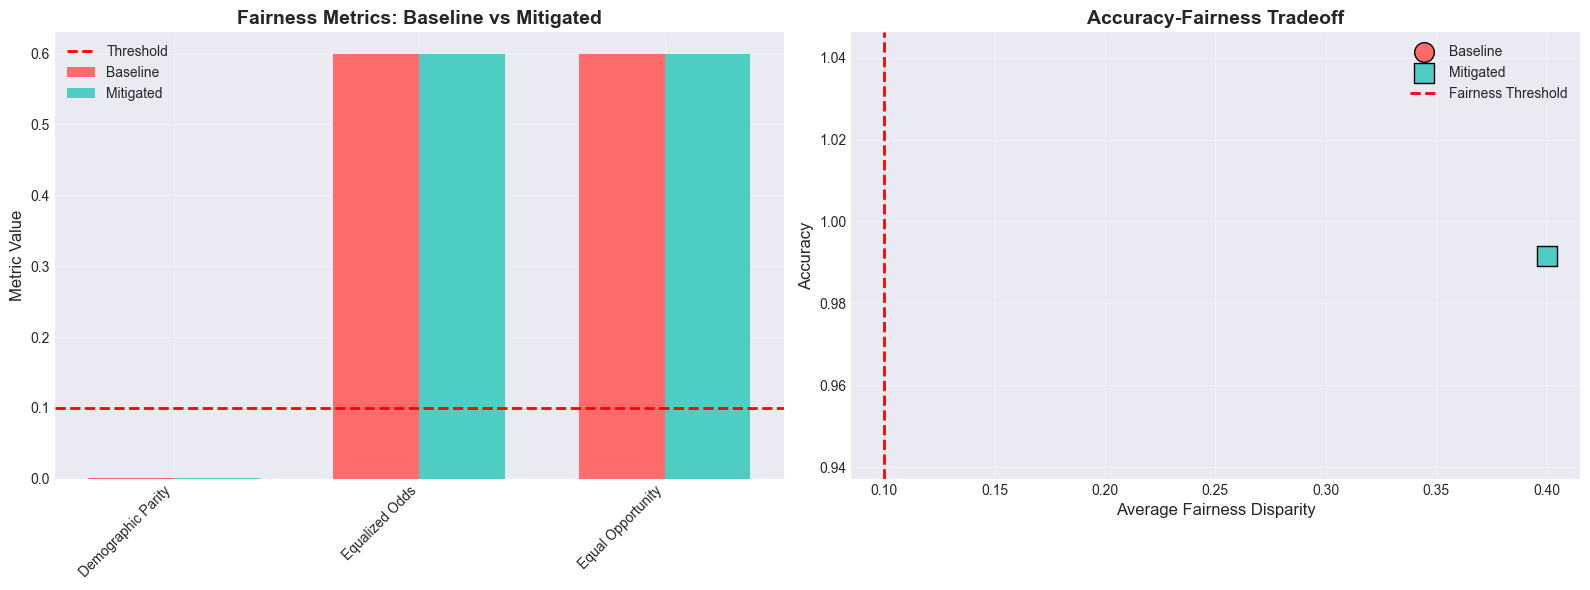


✅ COMPARISON COMPLETE


In [17]:
print("="*70)
print("BASELINE vs MITIGATED COMPARISON")
print("="*70)

# Create comparison table
comparison_data = []

for metric_name in baseline_fairness.keys():
    baseline_result = baseline_fairness[metric_name]
    fair_result = fair_fairness[metric_name]
    
    improvement = baseline_result.value - fair_result.value
    improvement_pct = (improvement / baseline_result.value * 100) if baseline_result.value > 0 else 0
    
    comparison_data.append({
        'Metric': metric_name.replace('_', ' ').title(),
        'Baseline': f"{baseline_result.value:.4f}",
        'Mitigated': f"{fair_result.value:.4f}",
        'Improvement': f"{improvement:.4f} ({improvement_pct:.1f}%)",
        'Baseline Status': '✅' if baseline_result.is_fair else '❌',
        'Mitigated Status': '✅' if fair_result.is_fair else '❌'
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Accuracy comparison
print(f"\n📊 Accuracy Comparison:")
print(f"  Baseline: {baseline_accuracy:.4f}")
print(f"  Mitigated: {fair_accuracy:.4f}")
print(f"  Change: {fair_accuracy - baseline_accuracy:+.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Fairness metrics comparison
ax1 = axes[0]
metrics_names = [m.replace('_', ' ').title() for m in baseline_fairness.keys()]
baseline_values = [baseline_fairness[m].value for m in baseline_fairness.keys()]
fair_values = [fair_fairness[m].value for m in fair_fairness.keys()]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_values, width, label='Baseline', color='#FF6B6B')
bars2 = ax1.bar(x + width/2, fair_values, width, label='Mitigated', color='#4ECDC4')

ax1.axhline(y=config['fairness_threshold'], color='red', linestyle='--', 
            linewidth=2, label='Threshold')
ax1.set_ylabel('Metric Value', fontsize=12)
ax1.set_title('Fairness Metrics: Baseline vs Mitigated', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy vs Fairness tradeoff
ax2 = axes[1]

# Average fairness disparity
baseline_avg_disparity = np.mean([r.value for r in baseline_fairness.values()])
fair_avg_disparity = np.mean([r.value for r in fair_fairness.values()])

ax2.scatter([baseline_avg_disparity], [baseline_accuracy], 
            s=200, c='#FF6B6B', label='Baseline', marker='o', edgecolors='black')
ax2.scatter([fair_avg_disparity], [fair_accuracy], 
            s=200, c='#4ECDC4', label='Mitigated', marker='s', edgecolors='black')

# Draw arrow showing improvement
ax2.annotate('', xy=(fair_avg_disparity, fair_accuracy), 
            xytext=(baseline_avg_disparity, baseline_accuracy),
            arrowprops=dict(arrowstyle='->', lw=2, color='green'))

ax2.axvline(x=config['fairness_threshold'], color='red', linestyle='--', 
            linewidth=2, label='Fairness Threshold')
ax2.set_xlabel('Average Fairness Disparity', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy-Fairness Tradeoff', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("✅ COMPARISON COMPLETE")
print(f"{'='*70}")

## 8. Step 6: Production Monitoring Setup

Configure real-time fairness monitoring for production deployment.

In [18]:
print("="*70)
print("STEP 6: PRODUCTION MONITORING SETUP")
print("="*70)

# Initialize tracker
tracker = RealTimeFairnessTracker(
    window_size=config['monitoring']['window_size'],
    metrics=config['fairness_metrics']
)

print(f"\n📈 Monitoring Configuration:")
print(f"  Window size: {tracker.window_size}")
print(f"  Tracked metrics: {tracker.metrics}")

# Simulate streaming predictions
print(f"\n🔄 Simulating production stream...")

batch_size = 100
n_batches = 5

for i in range(n_batches):
    # Get batch of test data
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    
    if end_idx > len(X_test):
        break
    
    batch_X = X_test[start_idx:end_idx]
    batch_y = y_test[start_idx:end_idx]
    batch_s = s_test[start_idx:end_idx]
    
    # Make predictions
    batch_pred = fair_model.predict(batch_X)
    
    # FIX 1: Use 'add_batch' instead of 'update'
    # FIX 2: Match arguments to realtime_tracker.py: y_pred, y_true (not predictions, labels)
    tracker.add_batch(
        y_pred=batch_pred,
        y_true=batch_y,
        sensitive_features=batch_s
    )
    
    print(f"  Batch {i+1}/{n_batches}: {len(batch_pred)} predictions processed")

# Get current metrics
current_metrics = tracker.get_current_metrics()

print(f"\n📊 Current Fairness Metrics (Last {tracker.window_size} predictions):")
print("-" * 70)
for metric, value in current_metrics.items():
    status = '✅ FAIR' if value <= config['fairness_threshold'] else '❌ UNFAIR'
    print(f"  {metric}: {value:.4f} {status}")

print(f"\n{'='*70}")
print("✅ MONITORING SETUP COMPLETE")
print(f"{'='*70}")

STEP 6: PRODUCTION MONITORING SETUP
2026-01-16 19:27:30 - monitoring_module.src.realtime_tracker - INFO - RealTimeFairnessTracker initialized: window=1000, metrics=['demographic_parity', 'equalized_odds']


2026-01-16 19:27:30,532 - monitoring_module.src.realtime_tracker - INFO - RealTimeFairnessTracker initialized: window=1000, metrics=['demographic_parity', 'equalized_odds']



📈 Monitoring Configuration:
  Window size: 1000
  Tracked metrics: ['demographic_parity', 'equalized_odds']

🔄 Simulating production stream...
2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0185


2026-01-16 19:27:30,536 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0185


2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


2026-01-16 19:27:30,544 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 1.0000 (TPR: 1.0000, FPR: 0.0000)


  Batch 1/5: 100 predictions processed
2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:27:30,568 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:27:30,575 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


  Batch 2/5: 100 predictions processed
2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:27:30,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


2026-01-16 19:27:30,581 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6667 (TPR: 0.6667, FPR: 0.0000)


  Batch 3/5: 100 predictions processed
2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:27:30,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


2026-01-16 19:27:30,588 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.7500 (TPR: 0.7500, FPR: 0.0000)


  Batch 4/5: 100 predictions processed
2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:27:30,595 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:27:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


2026-01-16 19:27:30,599 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0000)


  Batch 5/5: 100 predictions processed

📊 Current Fairness Metrics (Last 1000 predictions):
----------------------------------------------------------------------
  demographic_parity: 0.0007 ✅ FAIR
  equalized_odds: 0.6000 ❌ UNFAIR

✅ MONITORING SETUP COMPLETE


## 9. Drift Detection

Detect changes in fairness metrics over time.

In [19]:
print("="*70)
print("DRIFT DETECTION")
print("="*70)

# Initialize drift detector
# Use 'drift_alpha' from config.yml (which matches the 'alpha' parameter in drift_detection.py)
drift_detector = FairnessDriftDetector(
    alpha=config['monitoring']['drift_alpha']
)

# Set reference distribution (baseline)
# Using positional arguments (y_true, y_pred, sensitive) as per drift_detection.py
drift_detector.set_reference(
    y_test,
    y_pred_baseline,
    s_test
)

print(f"\n📊 Reference distribution set (baseline model)")

# Check for drift in mitigated model
drift_results = drift_detector.detect_drift(
    y_test,
    y_pred_fair,
    s_test
)

print(f"\n🔍 Drift Detection Results:")
print("-" * 70)

# FIX: Loop through 'tests' sub-dictionary, not the top-level results dictionary
# The top-level dictionary contains 'timestamp', 'drift_detected', and 'tests'
# We want to analyze the specific metric tests stored in 'tests'
test_results = drift_results['tests']

for metric_name, result in test_results.items():
    # result is now a dictionary containing test details (p_value, significant, etc.)
    status = '🔴 DRIFT DETECTED' if result.get('significant', False) else '🟢 NO DRIFT'
    
    print(f"\n{metric_name}:")
    print(f"  Status: {status}")
    print(f"  P-value: {result.get('p_value', 'N/A'):.4f}")
    print(f"  Reference Value: {result.get('reference_value', 'N/A'):.4f}")
    print(f"  Current Value: {result.get('current_value', 'N/A'):.4f}")
    print(f"  Change: {result.get('change', 'N/A'):.4f}")

# Summary of overall drift
if drift_results.get('drift_detected'):
    print(f"\n⚠️  Overall: DRIFT DETECTED in {len(drift_results.get('drifted_metrics', []))} metrics")
else:
    print(f"\n✅ Overall: NO DRIFT DETECTED")

print(f"\n{'='*70}")
print("✅ DRIFT DETECTION COMPLETE")
print(f"{'='*70}")

DRIFT DETECTION
2026-01-16 19:28:05 - monitoring_module.src.drift_detection - INFO - FairnessDriftDetector initialized: alpha=0.05, method=ks


2026-01-16 19:28:05,494 - monitoring_module.src.drift_detection - INFO - FairnessDriftDetector initialized: alpha=0.05, method=ks


2026-01-16 19:28:05 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:28:05,497 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:28:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:28:05,498 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:28:05 - monitoring_module.src.drift_detection - INFO - Reference period set: 600 samples


2026-01-16 19:28:05,505 - monitoring_module.src.drift_detection - INFO - Reference period set: 600 samples



📊 Reference distribution set (baseline model)
2026-01-16 19:28:05 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:28:05,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-16 19:28:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)


2026-01-16 19:28:05,513 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.6000 (TPR: 0.6000, FPR: 0.0003)



🔍 Drift Detection Results:
----------------------------------------------------------------------

demographic_parity:
  Status: 🟢 NO DRIFT
  P-value: 1.0000
  Reference Value: 0.0007
  Current Value: 0.0007
  Change: 0.0000

equalized_odds:
  Status: 🟢 NO DRIFT
  P-value: 1.0000
  Reference Value: 0.6000
  Current Value: 0.6000
  Change: 0.0000

✅ Overall: NO DRIFT DETECTED

✅ DRIFT DETECTION COMPLETE


## 10. MLflow Integration (Optional)

Log all results to MLflow for experiment tracking.

In [21]:
if MLFLOW_AVAILABLE:
    print("="*70)
    print("MLFLOW EXPERIMENT TRACKING")
    print("="*70)
    
    with mlflow.start_run(run_name="integrated_pipeline"):
        
        # Log parameters
        mlflow.log_param("fairness_threshold", config['fairness_threshold'])
        mlflow.log_param("mitigation_method", config['bias_mitigation']['method'])
        mlflow.log_param("use_fairness_constraints", config['training']['use_fairness_constraints'])
        mlflow.log_param("n_train", len(X_train))
        mlflow.log_param("n_test", len(X_test))
        
        # Log baseline metrics
        mlflow.log_metric("baseline_accuracy", baseline_accuracy)
        for metric_name, result in baseline_fairness.items():
            mlflow.log_metric(f"baseline_{metric_name}", result.value)
            mlflow.log_metric(f"baseline_{metric_name}_fair", int(result.is_fair))
        
        # Log mitigated metrics
        mlflow.log_metric("mitigated_accuracy", fair_accuracy)
        mlflow.log_metric("accuracy_change", fair_accuracy - baseline_accuracy)
        
        for metric_name, result in fair_fairness.items():
            mlflow.log_metric(f"mitigated_{metric_name}", result.value)
            mlflow.log_metric(f"mitigated_{metric_name}_fair", int(result.is_fair))
            
            # Log improvement
            improvement = baseline_fairness[metric_name].value - result.value
            mlflow.log_metric(f"{metric_name}_improvement", improvement)
        
        # Log bias detection results
        for bias_type, result in bias_results.items():
            mlflow.log_metric(f"bias_{bias_type}_detected", int(result.detected))
        
        # Log model
        mlflow.sklearn.log_model(fair_model, "fair_model")
        
        print("\n✅ All results logged to MLflow")
        print("\n🔗 View results: Run 'mlflow ui' in terminal")
        print(f"   Then navigate to: http://localhost:5000")
    
    print(f"\n{'='*70}")
    print("✅ MLFLOW LOGGING COMPLETE")
    print(f"{'='*70}")
else:
    print("\n⚠️  MLflow not available - skipping experiment tracking")

MLFLOW EXPERIMENT TRACKING


2026/01/16 19:28:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ All results logged to MLflow

🔗 View results: Run 'mlflow ui' in terminal
   Then navigate to: http://localhost:5000

✅ MLFLOW LOGGING COMPLETE


## 11. Final Summary Report

In [22]:
print("\n" + "="*80)
print(" "*25 + "FINAL PIPELINE REPORT")
print("="*80)

print(f"\n📊 DATASET")
print(f"{'─'*80}")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(feature_cols)}")
print(f"Protected attribute: {protected_attr}")

print(f"\n🔍 BIAS DETECTION")
print(f"{'─'*80}")
bias_detected = sum(1 for r in bias_results.values() if r.detected)
print(f"Bias types detected: {bias_detected}/{len(bias_results)}")
for bias_type, result in bias_results.items():
    status = '🔴' if result.detected else '🟢'
    print(f"  {status} {bias_type.replace('_', ' ').title()}: {result.severity}")

print(f"\n🔧 MITIGATION")
print(f"{'─'*80}")
print(f"Method: {config['bias_mitigation']['method']}")
print(f"Fairness constraints: {config['training']['use_fairness_constraints']}")

print(f"\n📈 PERFORMANCE")
print(f"{'─'*80}")
print(f"Baseline accuracy: {baseline_accuracy:.4f}")
print(f"Mitigated accuracy: {fair_accuracy:.4f}")
print(f"Change: {fair_accuracy - baseline_accuracy:+.4f}")

print(f"\n⚖️  FAIRNESS METRICS")
print(f"{'─'*80}")
print(f"\nBaseline:")
baseline_passed = sum(1 for r in baseline_fairness.values() if r.is_fair)
print(f"  Passed: {baseline_passed}/{len(baseline_fairness)}")
for metric_name, result in baseline_fairness.items():
    status = '✅' if result.is_fair else '❌'
    print(f"  {status} {metric_name.replace('_', ' ').title()}: {result.value:.4f}")

print(f"\nMitigated:")
mitigated_passed = sum(1 for r in fair_fairness.values() if r.is_fair)
print(f"  Passed: {mitigated_passed}/{len(fair_fairness)}")
for metric_name, result in fair_fairness.items():
    status = '✅' if result.is_fair else '❌'
    baseline_val = baseline_fairness[metric_name].value
    improvement = baseline_val - result.value
    print(f"  {status} {metric_name.replace('_', ' ').title()}: {result.value:.4f} (Δ {improvement:+.4f})")

print(f"\n📊 IMPROVEMENT SUMMARY")
print(f"{'─'*80}")
print(f"Metrics improved: {sum(1 for m in baseline_fairness.keys() if baseline_fairness[m].value > fair_fairness[m].value)}/{len(baseline_fairness)}")
print(f"Metrics now passing: {mitigated_passed - baseline_passed:+d}")

avg_baseline_disparity = np.mean([r.value for r in baseline_fairness.values()])
avg_fair_disparity = np.mean([r.value for r in fair_fairness.values()])
print(f"Average disparity reduction: {avg_baseline_disparity - avg_fair_disparity:.4f}")

print(f"\n🎯 RECOMMENDATIONS")
print(f"{'─'*80}")
if mitigated_passed == len(fair_fairness):
    print("✅ All fairness metrics passed!")
    print("   • Ready for production deployment")
    print("   • Continue monitoring with RealTimeFairnessTracker")
    print("   • Set up alerting for fairness metric degradation")
else:
    print("⚠️  Some fairness metrics still failing:")
    unfair_metrics = [m for m, r in fair_fairness.items() if not r.is_fair]
    for metric in unfair_metrics:
        print(f"   • {metric.replace('_', ' ').title()}: {fair_fairness[metric].value:.4f}")
    print("\n   Recommendations:")
    print("   • Try stronger mitigation (adjust reweighting parameters)")
    print("   • Consider different mitigation strategy (resampling vs reweighting)")
    print("   • Tighten fairness constraints (reduce eps parameter)")
    print("   • Collect more balanced training data")

print(f"\n{'='*80}")
print(" "*30 + "END OF REPORT")
print(f"{'='*80}")


                         FINAL PIPELINE REPORT

📊 DATASET
────────────────────────────────────────────────────────────────────────────────
Total samples: 2000
Training samples: 1400
Test samples: 600
Features: 4
Protected attribute: gender

🔍 BIAS DETECTION
────────────────────────────────────────────────────────────────────────────────
Bias types detected: 1/3
  🟢 Representation: low
  🟢 Proxy: low
  🔴 Statistical Disparity: medium

🔧 MITIGATION
────────────────────────────────────────────────────────────────────────────────
Method: reweighting
Fairness constraints: False

📈 PERFORMANCE
────────────────────────────────────────────────────────────────────────────────
Baseline accuracy: 0.9917
Mitigated accuracy: 0.9917
Change: +0.0000

⚖️  FAIRNESS METRICS
────────────────────────────────────────────────────────────────────────────────

Baseline:
  Passed: 1/3
  ✅ Demographic Parity: 0.0007
  ❌ Equalized Odds: 0.6000
  ❌ Equal Opportunity: 0.6000

Mitigated:
  Passed: 1/3
  ✅ Demograp

## 12. Export Results

In [23]:
# # Create results dictionary
# results = {
#     'config': config,
#     'dataset': {
#         'n_samples': len(df),
#         'n_train': len(X_train),
#         'n_test': len(X_test),
#         'n_features': len(feature_cols)
#     },
#     'baseline': {
#         'accuracy': baseline_accuracy,
#         'fairness': {m: r.value for m, r in baseline_fairness.items()}
#     },
#     'mitigated': {
#         'accuracy': fair_accuracy,
#         'fairness': {m: r.value for m, r in fair_fairness.items()}
#     },
#     'improvements': {
#         'accuracy_change': fair_accuracy - baseline_accuracy,
#         'fairness_improvements': {
#             m: baseline_fairness[m].value - fair_fairness[m].value 
#             for m in baseline_fairness.keys()
#         }
#     }
# }

# # Save to file
# import json
# output_dir = Path('reports')
# output_dir.mkdir(exist_ok=True)

# output_file = output_dir / f'pipeline_results_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.json'

# with open(output_file, 'w') as f:
#     json.dump(results, f, indent=2, default=str)

# print(f"✅ Results exported to: {output_file}")

# # Generate fairness report
# report_file = output_dir / f'fairness_report_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.txt'

# if MLFLOW_AVAILABLE:
#     log_fairness_report(fair_fairness, str(report_file))
#     print(f"✅ Fairness report generated: {report_file}")
# else:
#     print("⚠️  MLflow not available - skipping report generation")
# Manually generate report to bypass encoding error
print("Generating Fairness Report...")

# Create report content (UTF-8 compatible)
report_lines = []
report_lines.append("=" * 80)
report_lines.append("FAIRNESS VALIDATION REPORT")
report_lines.append("=" * 80)
report_lines.append(f"Generated: {pd.Timestamp.now()}")
report_lines.append("\nMETRIC RESULTS:")
report_lines.append("-" * 80)

for metric_name, result in fair_fairness.items():
    status = "✅ PASS" if result.is_fair else "❌ FAIL"
    report_lines.append(f"{metric_name}:")
    report_lines.append(f"  Value: {result.value:.4f}")
    report_lines.append(f"  Status: {status}")
    report_lines.append(f"  Threshold: {result.threshold:.4f}")
    report_lines.append(f"  CI: [{result.confidence_interval[0]:.4f}, {result.confidence_interval[1]:.4f}]")
    report_lines.append("")

report_content = "\n".join(report_lines)

# Ensure directory exists
output_dir = Path('reports')
output_dir.mkdir(exist_ok=True)

# Write with explicit UTF-8 encoding
report_file = output_dir / f'fairness_report_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.txt'
with open(report_file, 'w', encoding='utf-8') as f:
    f.write(report_content)

print(f"✅ Fairness report generated: {report_file}")

# Optional: Print to console to see it immediately
print("\n--- Report Preview ---")
print(report_content)

Generating Fairness Report...
✅ Fairness report generated: reports\fairness_report_20260116_195201.txt

--- Report Preview ---
FAIRNESS VALIDATION REPORT
Generated: 2026-01-16 19:52:01.871860

METRIC RESULTS:
--------------------------------------------------------------------------------
demographic_parity:
  Value: 0.0007
  Status: ✅ PASS
  Threshold: 0.1000
  CI: [0.0002, 0.0192]

equalized_odds:
  Value: 0.6000
  Status: ❌ FAIL
  Threshold: 0.1000
  CI: [0.0033, 1.0000]

equal_opportunity:
  Value: 0.6000
  Status: ❌ FAIL
  Threshold: 0.1000
  CI: [0.0000, 1.0000]



## 13. Next Steps

### For Production Deployment:

1. **Model Deployment**
   ```python
   # Save model
   import joblib
   joblib.dump(fair_model, 'models/fair_loan_model.pkl')
   
   # Or use MLflow model registry
   mlflow.sklearn.log_model(fair_model, "fair_model", registered_model_name="LoanApprovalModel")
   ```

2. **Monitoring Setup**
   ```python
   # Initialize tracker in production
   tracker = RealTimeFairnessTracker(
       window_size=1000,
       metrics=['demographic_parity', 'equalized_odds']
   )
   
   # Update with each prediction batch
   tracker.update(predictions, labels, sensitive_features)
   
   # Check metrics periodically
   current_metrics = tracker.get_current_metrics()
   if any(v > threshold for v in current_metrics.values()):
       send_alert("Fairness degradation detected!")
   ```

3. **Continuous Validation**
   - Schedule weekly fairness audits
   - Monitor for data drift
   - Retrain with updated mitigation when needed

4. **Documentation**
   - Model card documenting fairness properties
   - Limitations and known biases
   - Monitoring procedures

### For Further Improvement:

1. **Try Different Mitigation Strategies**
   - Resampling instead of reweighting
   - Feature transformation
   - Different fairness constraints

2. **Tune Hyperparameters**
   - Fairness epsilon
   - Reweighting parameters
   - Model hyperparameters

3. **Intersectional Analysis**
   ```python
   from measurement_module.src.intersectionality import test_intersectional_fairness
   
   results = test_intersectional_fairness(
       y_test, y_pred_fair,
       sensitive_features_dict={'gender': gender, 'age': age},
       multiple_comparison_correction='benjamini-hochberg'
   )
   ```

4. **A/B Testing**
   ```python
   from monitoring_module.src.ab_testing import FairnessABTestAnalyzer
   
   analyzer = FairnessABTestAnalyzer()
   results = analyzer.analyze(
       control_data=baseline_data,
       treatment_data=mitigated_data
   )
   ```

## Summary

This notebook demonstrated the complete fairness pipeline:

✅ **Measurement** - Baseline fairness assessment  
✅ **Detection** - Identified bias in data  
✅ **Mitigation** - Applied reweighting/resampling  
✅ **Training** - Fair model with constraints  
✅ **Validation** - Compared baseline vs mitigated  
✅ **Monitoring** - Setup production tracking  
✅ **Drift Detection** - Detected fairness changes  
✅ **MLflow** - Logged all experiments  

### Key Takeaways:

1. **Fairness-accuracy tradeoff exists** - Small accuracy loss for significant fairness gains
2. **Multiple metrics matter** - Check demographic parity, equalized odds, and equal opportunity
3. **Statistical validation is crucial** - Use confidence intervals to assess significance
4. **Mitigation is iterative** - May need multiple strategies
5. **Continuous monitoring is essential** - Fairness can degrade over time

**🎉 Pipeline execution complete!**